In [154]:
import pandas as pd
import py2neo as neo
from py2neo import Graph, Node, Relationship, Database
from py2neo.ogm import GraphObject, Property, RelatedTo
from py2neo.data import walk
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from py2neo.matching import NodeMatcher
import matplotlib
import matplotlib.pyplot as plt
import pickle
import networkx as nx

%load_ext cypher
%matplotlib inline

The cypher extension is already loaded. To reload it, use:
  %reload_ext cypher


# 1）读取原始数据

In [43]:
df_drugs = pd.read_excel('2000患者西药3.xlsx',sheet_name='Sheet1')
print(df_drugs.head())

     INPATIENT_NO            MO_NAME             real             pred   商品名  \
0  ZY060000520265  0.9%氯化钠注射液(科伦)&#@  XB05XA-XL211-02  XB05XA-XL211-02   氯化钠   
1  ZY010000568235      0.9%氯化钠注射液&#@  XB05XA-XL211-02  XB05XA-XL211-02   氯化钠   
2  ZY070000197897            肝素钠注射液#              NaN  XB01AB-XG047-02    肝素   
3  ZY010000504321             开瑞坦片*#  XR06AX-XL226-01  XR06AX-XL226-01  氯雷他定   
4  ZY060000341053    泮托拉唑钠肠溶胶囊(U比乐)#  XA02BC-XP025-01  XA02BC-XP025-01  泮托拉唑   

  给药途径  
0   注射  
1   注射  
2   注射  
3   口服  
4   口服  


In [4]:
print(df_drugs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171010 entries, 0 to 171009
Data columns (total 6 columns):
INPATIENT_NO    171010 non-null object
MO_NAME         171010 non-null object
real            150819 non-null object
pred            171010 non-null object
商品名             171010 non-null object
给药途径            171010 non-null object
dtypes: object(6)
memory usage: 7.8+ MB
None


In [14]:
print(len(df_drugs['INPATIENT_NO'].drop_duplicates()))

3053


In [26]:
print(len(df_drugs['pred'].drop_duplicates()))

806


In [39]:
print(len(df_drugs['给药途径'].drop_duplicates()))

17


In [40]:
df_patientInfo = pd.read_excel('患者信息整合 3-15 治疗路径用.xls',sheet_name='Sheet1')
print(df_patientInfo.head())
print(df_patientInfo.info())

           患者住院ID  患者个人ID（标识符）        患者所在医院  年龄 性别  居住地  民族     职业  身高  体重  \
0  ZY060000295315       295315  广州医科大学附属第一医院  74  男  NaN  汉族     农民 NaN NaN   
1  ZY060000338471       338471  广州医科大学附属第一医院  68  男  NaN  汉族  个体经营者 NaN NaN   
2  ZY050000341147       341147  广州医科大学附属第一医院  59  男  NaN  汉族  个体经营者 NaN NaN   
3  ZY020000329288       329288  广州医科大学附属第一医院  83  男  NaN  汉族  国家公务员 NaN NaN   
4  ZY020000350407       350407  广州医科大学附属第一医院  74  男  NaN  汉族  个体经营者 NaN NaN   

  ...  双下肢水肿 血嗜酸性粒细胞计数 痰嗜酸性粒细胞计数  C反应蛋白  白细胞 二氧化碳分压(测定) 肺泡动脉氧分压差   血沉 氧分压(测定)  \
0 ...    NaN       NaN       NaN    NaN  NaN        NaN      NaN  NaN     NaN   
1 ...    NaN       NaN       NaN    NaN  NaN        NaN      NaN  NaN     NaN   
2 ...    NaN       NaN       NaN    NaN  NaN        NaN      NaN  NaN     NaN   
3 ...    NaN       NaN       NaN    NaN  NaN        NaN      NaN  NaN     NaN   
4 ...    NaN       NaN       NaN    NaN  NaN        NaN      NaN  NaN     NaN   

   转归  
0  好转  
1  好转  
2  死亡  
3  好转 

In [43]:
print(list(df_patientInfo.columns))
list_diseases = ['高血压病', '高脂血症', '冠心病', '前列腺增生', '糖尿病', '焦虑', '抑郁', '心力衰竭', '心律失常', '脑卒中', 
                 '阻塞性睡眠呼吸暂停综合征', '骨质疏松', '类风湿性关节炎', '弥漫性肺间质纤维化', '肺癌', '肺栓塞', '肺源性心脏病', 
                 '白内障', '静脉栓塞和血栓形成', '哮喘', '动脉栓塞和血栓形成', '胃食管反流', '变应性鼻炎', '陈旧性肺结核', 
                 '低蛋白血症', '低钾血症', '肺癌术后', '肺结核', '肺气肿', '肺性脑病', '肺炎', '胸腔积液', '呼吸衰竭', 
                 '静脉炎和血栓性静脉炎', '慢性鼻炎', '慢性咽喉炎', '慢性支气管炎', '气胸', '支气管扩张', '心肌梗死', '心绞痛', 
                 '缺血性心肌病', '急性冠脉综合征', '胆管炎', '胆囊息肉', '胆石症', '风湿性心脏病', '腹股沟疝', '肝恶性肿瘤', 
                 '肝囊肿', '肝血管瘤', '肝硬化', '高尿酸血症', '急性肾衰竭', '甲状腺功能亢进症', '结肠癌', '结肠息肉', 
                 '结节性甲状腺肿', '结膜炎', '颈动脉硬化', '酒精性肝病', '扩张型心肌病', '慢性胆囊炎', '慢性肾脏疾病', 
                 '慢性十二指肠炎', '慢性胃炎', '门静脉血栓形成', '泌尿道感染', '脑动脉硬化', '脑萎缩', '帕金森病', '贫血', 
                 '青光眼', '肾结石', '肾囊肿', '声带息肉', '受压区褥疮', '痛风', '胃穿孔', '胃恶性肿瘤', '胃溃疡', 
                 '下肢动脉粥样硬化', '消化道出血', '心脏瓣膜病', '脂肪肝', '主动脉硬化', '椎管狭窄', '椎间盘突出']

['患者住院ID', '患者个人ID（标识符）', '患者所在医院', '年龄', '性别', '居住地', '民族', '职业', '身高', '体重', 'BMI', '入院类型', '所在科室', '住院时长', '症状首发年限', '1年内急性加重次数', '吸烟史', '已戒烟', '吸烟包年', '生物燃料暴露史', '主诉', '现病史', '家族史', '手术史', '输血史', '外伤史', '入院情况', '出院情况', '高血压病', '高脂血症', '冠心病', '前列腺增生', '糖尿病', '焦虑', '抑郁', '心力衰竭', '心律失常', '脑卒中', '阻塞性睡眠呼吸暂停综合征', '骨质疏松', '类风湿性关节炎', '弥漫性肺间质纤维化', '肺癌', '肺栓塞', '肺源性心脏病', '白内障', '静脉栓塞和血栓形成', '哮喘', '动脉栓塞和血栓形成', '胃食管反流', '变应性鼻炎', '陈旧性肺结核', '低蛋白血症', '低钾血症', '肺癌术后', '肺结核', '肺气肿', '肺性脑病', '肺炎', '胸腔积液', '呼吸衰竭', '静脉炎和血栓性静脉炎', '慢性鼻炎', '慢性咽喉炎', '慢性支气管炎', '气胸', '支气管扩张', '心肌梗死', '心绞痛', '缺血性心肌病', '急性冠脉综合征', '胆管炎', '胆囊息肉', '胆石症', '风湿性心脏病', '腹股沟疝', '肝恶性肿瘤', '肝囊肿', '肝血管瘤', '肝硬化', '高尿酸血症', '急性肾衰竭', '甲状腺功能亢进症', '结肠癌', '结肠息肉', '结节性甲状腺肿', '结膜炎', '颈动脉硬化', '酒精性肝病', '扩张型心肌病', '慢性胆囊炎', '慢性肾脏疾病', '慢性十二指肠炎', '慢性胃炎', '门静脉血栓形成', '泌尿道感染', '脑动脉硬化', '脑萎缩', '帕金森病', '贫血', '青光眼', '肾结石', '肾囊肿', '声带息肉', '受压区褥疮', '痛风', '胃穿孔', '胃恶性肿瘤', '胃溃疡', '下肢动脉粥样硬化', '消化道出血', '心脏瓣膜病', '脂肪肝', '主动脉硬化', '椎管狭窄', '椎间盘突出', '近期咳嗽', '既往咳嗽', '近期咳痰', 

In [2]:
df_drugRelation = pd.read_excel('诊断分类治疗路径3-21.xlsx',sheet_name='Sheet1')
df_drugRelation.head()

ID                                             诊断代码            诊断 ICD10分类  \
0 NaN                                  J44.000-J44.101  慢性阻塞性肺疾病急性加重  呼吸系统疾病   
1 NaN  J43.0,J43.1,J43.2,J43.8,J43.900,J43.903,J43.904           肺气肿  呼吸系统疾病   
2 NaN                                  J44.800-J44.900      慢性阻塞性肺疾病  呼吸系统疾病   
3 NaN                                          G47.302  阻塞性睡眠呼吸暂停综合征  呼吸系统疾病   
4 NaN                                              J47         支气管扩张  呼吸系统疾病   

     临床分类      科室                                             诊断（英文）   说明  \
0  呼吸系统疾病  呼吸内科专业  Acute exacerbation of chronic obstructive airw...  NaN   
1  呼吸系统疾病  呼吸内科专业                                          Emphysema  NaN   
2  呼吸系统疾病  呼吸内科专业                   Chronic obstructive lung disease  NaN   
3  呼吸系统疾病  呼吸内科专业                   Obstructive sleep apnea syndrome  NaN   
4  呼吸系统疾病  呼吸内科专业                                     Bronchiectasia  NaN   

    snomed编码  loinc编码  Unnamed: 10 Unnamed: 11 Unnamed: 12  
0  195951007      NaN          NaN        高血压病        高血压病  
1   87433001      NaN          NaN        高脂血症        高脂血症  
2   13645005      NaN          NaN         冠心病         冠心病  
3   78275009      NaN          NaN       前列腺增生       前列腺增生  
4   12295008      NaN          NaN         糖尿病         糖尿病

In [3]:
list_diseaseClass = list(df_drugRelation['临床分类'].drop_duplicates())
list_diseaseClass

['呼吸系统疾病',
 '消化系统疾病',
 '内分泌、营养和代谢疾病',
 '泌尿生殖系统疾病',
 '神经系统疾病',
 '循环系统疾病',
 '精神和行为障碍',
 '眼部疾病',
 '风湿性疾病',
 '血液系统疾病',
 '肌肉骨骼系统',
 '皮肤和皮下组织疾病']

In [24]:
df_drugInfo = pd.read_excel('药物知识图谱_实体及关系0308版.xls',sheet_name='商品名_通用名',dtype={'头主键值' : str})
df_drugInfo.head()

尾主键值     关系类型  头类型  尾类型  头主键名    头主键值  尾主键名     尾主键值.1
0   乙酰半胱氨酸颗粒  商品名_通用名  商品名  通用名  商品ID  104311  通用名称   乙酰半胱氨酸颗粒
1  乙酰半胱氨酸泡腾片  商品名_通用名  商品名  通用名  商品ID  104312  通用名称  乙酰半胱氨酸泡腾片
2  乙酰半胱氨酸注射液  商品名_通用名  商品名  通用名  商品ID  104313  通用名称  乙酰半胱氨酸注射液
3   乙酰半胱氨酸颗粒  商品名_通用名  商品名  通用名  商品ID  136088  通用名称   乙酰半胱氨酸颗粒
4  乙酰半胱氨酸喷雾剂  商品名_通用名  商品名  通用名  商品ID  136129  通用名称  乙酰半胱氨酸喷雾剂

In [25]:
dict_drugId_drugName = dict()
dict_drugName_drugId = dict()
for index,row in tqdm(df_drugInfo.iterrows(),total=df_drugInfo.shape[0]):
    dict_drugId_drugName[row['头主键值']] = row['尾主键值.1']
    dict_drugName_drugId[row['尾主键值.1']] = row['头主键值']
    
print(dict_drugId_drugName)


100%|██████████| 6202/6202 [00:00<00:00, 6522.52it/s]

{'104311': '乙酰半胱氨酸颗粒', '104312': '乙酰半胱氨酸泡腾片', '104313': '乙酰半胱氨酸注射液', '136088': '乙酰半胱氨酸颗粒', '136129': '乙酰半胱氨酸喷雾剂', '136572': '乙酰半胱氨酸片', '149102': '吸入用乙酰半胱氨酸溶液', '158588': '乙酰半胱氨酸胶囊', '162772': '乙酰半胱氨酸颗粒', '171789': '乙酰半胱氨酸滴眼液', '174187': '乙酰半胱氨酸片', '176488': '乙酰半胱氨酸泡腾片', '176573': '吸入用乙酰半胱氨酸溶液', '180457': '乙酰半胱氨酸泡腾片', '49295': '锝99mTc双半胱氨酸注射液', '50597': '注射用亚锡双半胱氨酸', '104579': '注射用盐酸万古霉素', '47303': '注射用盐酸去甲万古霉素', '50617': '注射用盐酸去甲万古霉素', '136040': '三硅酸镁片', '104161': '盐酸丙卡特罗口服溶液', '104162': '盐酸丙卡特罗片', '104163': '盐酸丙卡特罗气雾剂', '149248': '盐酸丙卡特罗片', '149250': '盐酸丙卡特罗口服溶液', '149302': '盐酸丙卡特罗口服溶液', '158338': '盐酸丙卡特罗颗粒剂', '159767': '盐酸丙卡特罗口服溶液', '161161': '盐酸丙卡特罗胶囊', '169754': '盐酸丙卡特罗片', '172449': '盐酸丙卡特罗口服溶液', '173981': '盐酸丙卡特罗颗粒', '176289': '盐酸丙卡特罗片', '50204': '盐酸丙卡特罗胶囊', '50205': '盐酸丙卡特罗片', '169292': '注射用盐酸丙帕他莫', '171425': '注射用盐酸丙帕他莫', '102968': '丙硫异烟胺肠溶片', '166880': '丙硫异烟胺肠溶片', '167302': '丙硫异烟胺肠溶片', '49201': '丙硫异烟胺片', '135505': '复方丙谷胺西咪替丁片', '149560': '丙谷胺片', '149575': '丙谷胺胶囊', '157154': '丙谷胺

In [20]:
df_drugRelation = pd.read_excel('药物知识图谱_实体及关系0308版.xls',sheet_name='√ 适应症',dtype = {'头主键值' : str})
df_drugRelation.head()

关系类型  头类型 尾类型  头主键名    头主键值  尾主键名        尾主键值 属性名1  \
0  适应症  商品名  疾病  商品ID  100005  疾病名称  于克拉霉素敏感列感染   答语   
1  适应症  商品名  疾病  商品ID  100005  疾病名称        鼻咽感染   答语   
2  适应症  商品名  疾病  商品ID  100005  疾病名称        扁桃体炎   答语   
3  适应症  商品名  疾病  商品ID  100005  疾病名称          咽炎   答语   
4  适应症  商品名  疾病  商品ID  100005  疾病名称         鼻窦炎   答语   

                                      属性值1  Unnamed: 9  Unnamed: 10 症状对齐  \
0  O适用于克拉霉素敏感菌所引起的下列感染：O1.鼻咽感染：扁桃体炎、咽炎、鼻窦炎         NaN          NaN  NaN   
1  O适用于克拉霉素敏感菌所引起的下列感染：O1.鼻咽感染：扁桃体炎、咽炎、鼻窦炎         NaN          NaN  NaN   
2  O适用于克拉霉素敏感菌所引起的下列感染：O1.鼻咽感染：扁桃体炎、咽炎、鼻窦炎         NaN          NaN  NaN   
3  O适用于克拉霉素敏感菌所引起的下列感染：O1.鼻咽感染：扁桃体炎、咽炎、鼻窦炎         NaN          NaN  NaN   
4  O适用于克拉霉素敏感菌所引起的下列感染：O1.鼻咽感染：扁桃体炎、咽炎、鼻窦炎         NaN          NaN  NaN   

        疾病对齐     汇总对齐结果  
0  克拉霉素敏感列感染  克拉霉素敏感列感染  
1      鼻咽部感染      鼻咽部感染  
2       扁桃体炎       扁桃体炎  
3         咽炎         咽炎  
4        鼻窦炎        鼻窦炎

# 2）定义OGM类别

In [45]:
class Inpatient_NO(GraphObject):
    __primarykey__ = 'inpatient_NO'

    inpatient_NO = Property()
    hospitalized_timeLength = Property()
    has_disease = RelatedTo('Disease','HAS_DISEASE')
    use = RelatedTo('Drug', 'USES')

In [46]:
class Drug(GraphObject):
    __primarykey__ = 'drug_standardCode'

    drug_standardCode = Property()
    drug_name = Property()
    drug_provideMethod = Property()
    drug_goodsId = Property()
    
    effective_to = RelatedTo('Disease','EFFECTIVE_TO')

In [47]:
class Patient(GraphObject):
    __primarykey__ = 'patient_ID'

    patient_ID = Property()
    age = Property()
    sex = Property()
    hospitalized = RelatedTo('Inpatient_NO','HOSPITALIZED')

In [48]:
class Disease(GraphObject):
    __primarykey__ = 'disease_name'

    disease_name = Property()
    belong_to_class = RelatedTo('DiseaseClass','BELONG_TO_CLASS')

In [49]:
class DiseaseClass(GraphObject):
    __primarykey__ = 'disease_class_name'

    disease_class_name = Property()

# 3）生成图数据库

In [2]:
db = Database("bolt://127.0.0.1:7687", password = '123456')
print(db)

<Database uri='bolt://127.0.0.1:7687' secure=False user_agent='py2neo/4.2.0 neobolt/1.7.4 Python/3.6.8-final-0 (darwin)'>


In [3]:
graph = Graph("bolt://127.0.0.1:7687", auth=("neo4j","123456"))
print(graph)

<Graph database=<Database uri='bolt://127.0.0.1:7687' secure=False user_agent='py2neo/4.2.0 neobolt/1.7.4 Python/3.6.8-final-0 (darwin)'> name='data'>


In [21]:
# graph.delete_all()

In [50]:
for index,row in tqdm(df_drugs.iterrows(), total=df_drugs.shape[0]):
    oneNode = Inpatient_NO()
    oneNode.inpatient_NO = row['INPATIENT_NO']
    
    drugNode = Drug()
    drugNode.drug_standardCode = row['pred']
    drugNode.drug_name = row['商品名']
    drugNode.drug_provideMethod = row['给药途径']
    
    oneNode.use.add(drugNode)
    
    graph.push(oneNode) 







  0%|          | 0/171010 [00:00<?, ?it/s]





  0%|          | 1/171010 [00:00<11:26:36,  4.15it/s]





  0%|          | 4/171010 [00:00<8:36:43,  5.52it/s] 





  0%|          | 7/171010 [00:00<6:34:48,  7.22it/s]





  0%|          | 14/171010 [00:00<4:49:24,  9.85it/s]





  0%|          | 21/171010 [00:00<3:35:23, 13.23it/s]





  0%|          | 28/171010 [00:00<2:43:10, 17.46it/s]





  0%|          | 35/171010 [00:00<2:09:38, 21.98it/s]





  0%|          | 41/171010 [00:01<1:55:46, 24.61it/s]





  0%|          | 47/171010 [00:01<1:35:37, 29.80it/s]





  0%|          | 54/171010 [00:01<1:19:35, 35.80it/s]





  0%|          | 62/171010 [00:01<1:07:26, 42.24it/s]





  0%|          | 69/171010 [00:01<1:02:49, 45.35it/s]





  0%|          | 76/171010 [00:01<57:10, 49.83it/s]  





  0%|          | 83/171010 [00:01<52:37, 54.13it/s]





  0%|          | 90/171010 [00:01<51:53, 54.90it/s]





  0%|          | 98/171010 [00:01<47:19, 60.19it/s]





  0%|    

  1%|          | 1884/171010 [00:24<32:22, 87.05it/s]





  1%|          | 1894/171010 [00:24<33:30, 84.13it/s]





  1%|          | 1903/171010 [00:24<32:52, 85.74it/s]





  1%|          | 1914/171010 [00:24<30:58, 90.96it/s]





  1%|          | 1925/171010 [00:24<29:31, 95.43it/s]





  1%|          | 1936/171010 [00:24<28:27, 99.00it/s]





  1%|          | 1947/171010 [00:24<28:16, 99.66it/s]





  1%|          | 1958/171010 [00:24<27:47, 101.37it/s]





  1%|          | 1969/171010 [00:25<27:25, 102.74it/s]





  1%|          | 1980/171010 [00:25<27:40, 101.78it/s]





  1%|          | 1991/171010 [00:25<27:57, 100.75it/s]





  1%|          | 2002/171010 [00:25<27:27, 102.61it/s]





  1%|          | 2013/171010 [00:25<27:15, 103.34it/s]





  1%|          | 2024/171010 [00:25<29:00, 97.08it/s] 





  1%|          | 2034/171010 [00:25<31:53, 88.31it/s]





  1%|          | 2044/171010 [00:25<31:12, 90.26it/s]





  1%|          | 2054/171010 [00:25<33:33, 83.90i

  2%|▏         | 4079/171010 [00:47<24:57, 111.49it/s]





  2%|▏         | 4091/171010 [00:47<25:00, 111.25it/s]





  2%|▏         | 4103/171010 [00:48<24:55, 111.63it/s]





  2%|▏         | 4115/171010 [00:48<25:08, 110.64it/s]





  2%|▏         | 4127/171010 [00:48<25:06, 110.76it/s]





  2%|▏         | 4139/171010 [00:48<25:00, 111.25it/s]





  2%|▏         | 4151/171010 [00:48<25:00, 111.21it/s]





  2%|▏         | 4163/171010 [00:48<24:55, 111.54it/s]





  2%|▏         | 4175/171010 [00:48<25:01, 111.11it/s]





  2%|▏         | 4187/171010 [00:48<24:44, 112.38it/s]





  2%|▏         | 4199/171010 [00:48<26:44, 103.98it/s]





  2%|▏         | 4210/171010 [00:49<26:19, 105.61it/s]





  2%|▏         | 4222/171010 [00:49<25:49, 107.67it/s]





  2%|▏         | 4234/171010 [00:49<25:29, 109.08it/s]





  2%|▏         | 4246/171010 [00:49<25:14, 110.11it/s]





  2%|▏         | 4258/171010 [00:49<25:13, 110.18it/s]





  2%|▏         | 4270/171010 [00:49<25:0

  4%|▎         | 6349/171010 [01:11<41:56, 65.43it/s]





  4%|▎         | 6356/171010 [01:11<45:10, 60.74it/s]





  4%|▎         | 6363/171010 [01:11<45:21, 60.51it/s]





  4%|▎         | 6370/171010 [01:12<44:18, 61.93it/s]





  4%|▎         | 6380/171010 [01:12<39:44, 69.04it/s]





  4%|▎         | 6388/171010 [01:12<38:35, 71.10it/s]





  4%|▎         | 6397/171010 [01:12<36:31, 75.12it/s]





  4%|▎         | 6407/171010 [01:12<34:29, 79.56it/s]





  4%|▍         | 6416/171010 [01:12<35:50, 76.54it/s]





  4%|▍         | 6426/171010 [01:12<33:37, 81.59it/s]





  4%|▍         | 6437/171010 [01:12<31:15, 87.73it/s]





  4%|▍         | 6448/171010 [01:12<29:44, 92.20it/s]





  4%|▍         | 6458/171010 [01:12<30:17, 90.54it/s]





  4%|▍         | 6468/171010 [01:13<29:50, 91.89it/s]





  4%|▍         | 6478/171010 [01:13<31:46, 86.29it/s]





  4%|▍         | 6487/171010 [01:13<37:38, 72.86it/s]





  4%|▍         | 6499/171010 [01:13<33:39, 81.46it/s]




  5%|▌         | 8683/171010 [01:34<23:18, 116.05it/s]





  5%|▌         | 8695/171010 [01:35<23:15, 116.28it/s]





  5%|▌         | 8707/171010 [01:35<23:18, 116.09it/s]





  5%|▌         | 8719/171010 [01:35<23:16, 116.18it/s]





  5%|▌         | 8731/171010 [01:35<23:20, 115.84it/s]





  5%|▌         | 8743/171010 [01:35<23:20, 115.89it/s]





  5%|▌         | 8755/171010 [01:35<23:17, 116.07it/s]





  5%|▌         | 8767/171010 [01:35<23:21, 115.74it/s]





  5%|▌         | 8779/171010 [01:35<23:19, 115.90it/s]





  5%|▌         | 8791/171010 [01:35<23:20, 115.79it/s]





  5%|▌         | 8803/171010 [01:35<23:39, 114.29it/s]





  5%|▌         | 8815/171010 [01:36<23:29, 115.09it/s]





  5%|▌         | 8827/171010 [01:36<23:35, 114.60it/s]





  5%|▌         | 8839/171010 [01:36<24:09, 111.90it/s]





  5%|▌         | 8851/171010 [01:36<26:59, 100.14it/s]





  5%|▌         | 8863/171010 [01:36<26:07, 103.47it/s]





  5%|▌         | 8874/171010 [01:36<26:3

  6%|▋         | 11091/171010 [01:58<25:50, 103.15it/s]





  6%|▋         | 11103/171010 [01:58<24:57, 106.76it/s]





  6%|▋         | 11115/171010 [01:58<24:20, 109.49it/s]





  7%|▋         | 11127/171010 [01:58<24:05, 110.57it/s]





  7%|▋         | 11139/171010 [01:58<23:55, 111.37it/s]





  7%|▋         | 11151/171010 [01:58<23:45, 112.15it/s]





  7%|▋         | 11163/171010 [01:58<23:54, 111.42it/s]





  7%|▋         | 11175/171010 [01:59<23:47, 111.99it/s]





  7%|▋         | 11187/171010 [01:59<23:32, 113.15it/s]





  7%|▋         | 11199/171010 [01:59<23:23, 113.85it/s]





  7%|▋         | 11211/171010 [01:59<23:13, 114.64it/s]





  7%|▋         | 11223/171010 [01:59<23:27, 113.52it/s]





  7%|▋         | 11235/171010 [01:59<23:20, 114.06it/s]





  7%|▋         | 11247/171010 [01:59<23:10, 114.88it/s]





  7%|▋         | 11259/171010 [01:59<23:03, 115.47it/s]





  7%|▋         | 11271/171010 [01:59<22:57, 115.94it/s]





  7%|▋         | 11283/1

  8%|▊         | 13337/171010 [02:21<29:34, 88.85it/s]





  8%|▊         | 13347/171010 [02:21<30:45, 85.44it/s]





  8%|▊         | 13356/171010 [02:21<32:40, 80.41it/s]





  8%|▊         | 13365/171010 [02:21<33:25, 78.59it/s]





  8%|▊         | 13374/171010 [02:21<34:47, 75.50it/s]





  8%|▊         | 13382/171010 [02:21<36:37, 71.75it/s]





  8%|▊         | 13390/171010 [02:21<35:53, 73.20it/s]





  8%|▊         | 13398/171010 [02:22<37:17, 70.45it/s]





  8%|▊         | 13406/171010 [02:22<39:39, 66.24it/s]





  8%|▊         | 13413/171010 [02:22<41:33, 63.20it/s]





  8%|▊         | 13420/171010 [02:22<42:02, 62.48it/s]





  8%|▊         | 13430/171010 [02:22<37:52, 69.35it/s]





  8%|▊         | 13438/171010 [02:22<38:38, 67.95it/s]





  8%|▊         | 13449/171010 [02:22<34:32, 76.01it/s]





  8%|▊         | 13461/171010 [02:22<31:02, 84.60it/s]





  8%|▊         | 13473/171010 [02:22<28:24, 92.40it/s]





  8%|▊         | 13485/171010 [02:23<26:

  9%|▉         | 15704/171010 [02:43<23:09, 111.79it/s]





  9%|▉         | 15716/171010 [02:44<23:26, 110.40it/s]





  9%|▉         | 15728/171010 [02:44<23:24, 110.58it/s]





  9%|▉         | 15740/171010 [02:44<23:25, 110.50it/s]





  9%|▉         | 15752/171010 [02:44<23:12, 111.51it/s]





  9%|▉         | 15764/171010 [02:44<23:14, 111.35it/s]





  9%|▉         | 15776/171010 [02:44<23:11, 111.53it/s]





  9%|▉         | 15788/171010 [02:44<23:32, 109.87it/s]





  9%|▉         | 15800/171010 [02:44<23:19, 110.90it/s]





  9%|▉         | 15812/171010 [02:44<23:25, 110.39it/s]





  9%|▉         | 15824/171010 [02:45<23:23, 110.53it/s]





  9%|▉         | 15836/171010 [02:45<23:24, 110.48it/s]





  9%|▉         | 15848/171010 [02:45<23:15, 111.15it/s]





  9%|▉         | 15860/171010 [02:45<23:23, 110.51it/s]





  9%|▉         | 15872/171010 [02:45<23:52, 108.34it/s]





  9%|▉         | 15883/171010 [02:45<23:46, 108.74it/s]





  9%|▉         | 15895/1

 10%|█         | 17860/171010 [03:08<29:31, 86.46it/s]





 10%|█         | 17869/171010 [03:08<31:11, 81.84it/s]





 10%|█         | 17878/171010 [03:08<32:54, 77.55it/s]





 10%|█         | 17886/171010 [03:08<35:46, 71.33it/s]





 10%|█         | 17894/171010 [03:08<36:45, 69.41it/s]





 10%|█         | 17902/171010 [03:08<39:16, 64.97it/s]





 10%|█         | 17911/171010 [03:08<36:54, 69.13it/s]





 10%|█         | 17921/171010 [03:09<34:05, 74.85it/s]





 10%|█         | 17931/171010 [03:09<31:37, 80.67it/s]





 10%|█         | 17941/171010 [03:09<29:52, 85.37it/s]





 10%|█         | 17952/171010 [03:09<28:21, 89.93it/s]





 11%|█         | 17962/171010 [03:09<27:35, 92.43it/s]





 11%|█         | 17972/171010 [03:09<26:59, 94.47it/s]





 11%|█         | 17983/171010 [03:09<26:16, 97.08it/s]





 11%|█         | 17994/171010 [03:09<25:34, 99.74it/s]





 11%|█         | 18005/171010 [03:09<27:32, 92.59it/s]





 11%|█         | 18016/171010 [03:10<26:

 12%|█▏        | 20234/171010 [03:30<23:13, 108.19it/s]





 12%|█▏        | 20245/171010 [03:30<23:41, 106.03it/s]





 12%|█▏        | 20257/171010 [03:30<23:18, 107.78it/s]





 12%|█▏        | 20269/171010 [03:31<22:52, 109.82it/s]





 12%|█▏        | 20281/171010 [03:31<24:58, 100.61it/s]





 12%|█▏        | 20292/171010 [03:31<25:14, 99.53it/s] 





 12%|█▏        | 20303/171010 [03:31<24:46, 101.41it/s]





 12%|█▏        | 20315/171010 [03:31<24:08, 104.02it/s]





 12%|█▏        | 20327/171010 [03:31<23:27, 107.08it/s]





 12%|█▏        | 20339/171010 [03:31<23:02, 108.97it/s]





 12%|█▏        | 20350/171010 [03:31<23:03, 108.87it/s]





 12%|█▏        | 20362/171010 [03:31<22:47, 110.15it/s]





 12%|█▏        | 20374/171010 [03:32<23:09, 108.45it/s]





 12%|█▏        | 20385/171010 [03:32<23:18, 107.74it/s]





 12%|█▏        | 20396/171010 [03:32<24:54, 100.81it/s]





 12%|█▏        | 20407/171010 [03:32<25:54, 96.87it/s] 





 12%|█▏        | 20420/1

 13%|█▎        | 22662/171010 [03:53<20:31, 120.51it/s]





 13%|█▎        | 22675/171010 [03:53<20:35, 120.08it/s]





 13%|█▎        | 22688/171010 [03:54<20:31, 120.40it/s]





 13%|█▎        | 22701/171010 [03:54<20:31, 120.47it/s]





 13%|█▎        | 22714/171010 [03:54<23:08, 106.79it/s]





 13%|█▎        | 22725/171010 [03:54<26:16, 94.08it/s] 





 13%|█▎        | 22737/171010 [03:54<24:55, 99.18it/s]





 13%|█▎        | 22750/171010 [03:54<23:36, 104.66it/s]





 13%|█▎        | 22762/171010 [03:54<22:45, 108.53it/s]





 13%|█▎        | 22775/171010 [03:54<22:04, 111.95it/s]





 13%|█▎        | 22788/171010 [03:55<21:32, 114.68it/s]





 13%|█▎        | 22801/171010 [03:55<21:07, 116.96it/s]





 13%|█▎        | 22814/171010 [03:55<20:54, 118.16it/s]





 13%|█▎        | 22827/171010 [03:55<20:46, 118.91it/s]





 13%|█▎        | 22839/171010 [03:55<21:08, 116.79it/s]





 13%|█▎        | 22852/171010 [03:55<20:52, 118.30it/s]





 13%|█▎        | 22864/17

 15%|█▍        | 25123/171010 [04:16<21:41, 112.05it/s]





 15%|█▍        | 25135/171010 [04:16<21:32, 112.86it/s]





 15%|█▍        | 25147/171010 [04:16<21:16, 114.27it/s]





 15%|█▍        | 25159/171010 [04:17<21:02, 115.56it/s]





 15%|█▍        | 25171/171010 [04:17<20:56, 116.02it/s]





 15%|█▍        | 25183/171010 [04:17<21:06, 115.17it/s]





 15%|█▍        | 25195/171010 [04:17<21:03, 115.44it/s]





 15%|█▍        | 25207/171010 [04:17<21:27, 113.28it/s]





 15%|█▍        | 25219/171010 [04:17<21:21, 113.75it/s]





 15%|█▍        | 25232/171010 [04:17<20:59, 115.70it/s]





 15%|█▍        | 25244/171010 [04:17<21:01, 115.55it/s]





 15%|█▍        | 25256/171010 [04:17<22:18, 108.89it/s]





 15%|█▍        | 25267/171010 [04:18<23:34, 103.07it/s]





 15%|█▍        | 25279/171010 [04:18<22:46, 106.65it/s]





 15%|█▍        | 25292/171010 [04:18<21:59, 110.46it/s]





 15%|█▍        | 25304/171010 [04:18<21:49, 111.23it/s]





 15%|█▍        | 25317/1

 16%|█▌        | 27574/171010 [04:38<20:20, 117.50it/s]





 16%|█▌        | 27587/171010 [04:38<20:09, 118.57it/s]





 16%|█▌        | 27599/171010 [04:39<20:14, 118.08it/s]





 16%|█▌        | 27611/171010 [04:39<20:10, 118.51it/s]





 16%|█▌        | 27624/171010 [04:39<20:00, 119.43it/s]





 16%|█▌        | 27636/171010 [04:39<19:59, 119.53it/s]





 16%|█▌        | 27648/171010 [04:39<20:22, 117.29it/s]





 16%|█▌        | 27660/171010 [04:39<20:29, 116.59it/s]





 16%|█▌        | 27673/171010 [04:39<20:13, 118.13it/s]





 16%|█▌        | 27686/171010 [04:39<20:04, 119.01it/s]





 16%|█▌        | 27699/171010 [04:39<19:52, 120.14it/s]





 16%|█▌        | 27712/171010 [04:39<19:58, 119.59it/s]





 16%|█▌        | 27724/171010 [04:40<20:16, 117.77it/s]





 16%|█▌        | 27736/171010 [04:40<20:09, 118.43it/s]





 16%|█▌        | 27748/171010 [04:40<20:43, 115.25it/s]





 16%|█▌        | 27760/171010 [04:40<21:17, 112.16it/s]





 16%|█▌        | 27772/1

 18%|█▊        | 30077/171010 [05:00<21:31, 109.09it/s]





 18%|█▊        | 30088/171010 [05:01<22:54, 102.52it/s]





 18%|█▊        | 30099/171010 [05:01<24:18, 96.59it/s] 





 18%|█▊        | 30109/171010 [05:01<25:05, 93.58it/s]





 18%|█▊        | 30122/171010 [05:01<23:24, 100.31it/s]





 18%|█▊        | 30134/171010 [05:01<23:19, 100.65it/s]





 18%|█▊        | 30145/171010 [05:01<24:00, 97.78it/s] 





 18%|█▊        | 30156/171010 [05:01<23:34, 99.60it/s]





 18%|█▊        | 30167/171010 [05:01<24:56, 94.09it/s]





 18%|█▊        | 30177/171010 [05:01<25:54, 90.59it/s]





 18%|█▊        | 30188/171010 [05:02<25:06, 93.46it/s]





 18%|█▊        | 30199/171010 [05:02<24:04, 97.47it/s]





 18%|█▊        | 30212/171010 [05:02<22:41, 103.41it/s]





 18%|█▊        | 30224/171010 [05:02<21:45, 107.82it/s]





 18%|█▊        | 30236/171010 [05:02<21:20, 109.93it/s]





 18%|█▊        | 30248/171010 [05:02<21:05, 111.26it/s]





 18%|█▊        | 30260/171010 

 19%|█▉        | 32482/171010 [05:23<19:51, 116.28it/s]





 19%|█▉        | 32494/171010 [05:23<25:20, 91.13it/s] 





 19%|█▉        | 32504/171010 [05:23<25:21, 91.05it/s]





 19%|█▉        | 32516/171010 [05:24<23:44, 97.19it/s]





 19%|█▉        | 32528/171010 [05:24<22:29, 102.65it/s]





 19%|█▉        | 32539/171010 [05:24<22:14, 103.76it/s]





 19%|█▉        | 32550/171010 [05:24<25:42, 89.74it/s] 





 19%|█▉        | 32561/171010 [05:24<24:29, 94.20it/s]





 19%|█▉        | 32572/171010 [05:24<23:44, 97.21it/s]





 19%|█▉        | 32584/171010 [05:24<22:48, 101.14it/s]





 19%|█▉        | 32596/171010 [05:24<21:44, 106.10it/s]





 19%|█▉        | 32609/171010 [05:24<20:58, 110.00it/s]





 19%|█▉        | 32622/171010 [05:25<20:21, 113.32it/s]





 19%|█▉        | 32635/171010 [05:25<19:59, 115.33it/s]





 19%|█▉        | 32647/171010 [05:25<20:01, 115.14it/s]





 19%|█▉        | 32659/171010 [05:25<19:55, 115.71it/s]





 19%|█▉        | 32671/17101

 20%|██        | 34948/171010 [05:46<21:05, 107.49it/s]





 20%|██        | 34959/171010 [05:46<21:01, 107.83it/s]





 20%|██        | 34970/171010 [05:46<21:01, 107.88it/s]





 20%|██        | 34981/171010 [05:46<21:04, 107.53it/s]





 20%|██        | 34992/171010 [05:46<21:01, 107.83it/s]





 20%|██        | 35004/171010 [05:46<20:46, 109.12it/s]





 20%|██        | 35016/171010 [05:46<20:29, 110.60it/s]





 20%|██        | 35028/171010 [05:46<20:19, 111.52it/s]





 20%|██        | 35040/171010 [05:46<20:43, 109.36it/s]





 20%|██        | 35051/171010 [05:47<21:11, 106.95it/s]





 21%|██        | 35062/171010 [05:47<21:00, 107.83it/s]





 21%|██        | 35073/171010 [05:47<21:17, 106.39it/s]





 21%|██        | 35084/171010 [05:47<21:38, 104.69it/s]





 21%|██        | 35095/171010 [05:47<21:25, 105.74it/s]





 21%|██        | 35106/171010 [05:47<21:16, 106.51it/s]





 21%|██        | 35117/171010 [05:47<21:13, 106.71it/s]





 21%|██        | 35129/1

 22%|██▏       | 37383/171010 [06:08<20:36, 108.04it/s]





 22%|██▏       | 37395/171010 [06:08<20:16, 109.88it/s]





 22%|██▏       | 37407/171010 [06:08<20:51, 106.77it/s]





 22%|██▏       | 37420/171010 [06:08<20:03, 110.98it/s]





 22%|██▏       | 37432/171010 [06:08<19:55, 111.69it/s]





 22%|██▏       | 37445/171010 [06:08<19:27, 114.43it/s]





 22%|██▏       | 37458/171010 [06:08<19:09, 116.20it/s]





 22%|██▏       | 37470/171010 [06:09<19:06, 116.49it/s]





 22%|██▏       | 37482/171010 [06:09<19:15, 115.51it/s]





 22%|██▏       | 37494/171010 [06:09<19:38, 113.29it/s]





 22%|██▏       | 37507/171010 [06:09<19:14, 115.63it/s]





 22%|██▏       | 37520/171010 [06:09<18:58, 117.27it/s]





 22%|██▏       | 37532/171010 [06:09<19:59, 111.26it/s]





 22%|██▏       | 37544/171010 [06:09<20:27, 108.73it/s]





 22%|██▏       | 37555/171010 [06:09<20:25, 108.86it/s]





 22%|██▏       | 37567/171010 [06:09<20:05, 110.72it/s]





 22%|██▏       | 37580/1

 23%|██▎       | 38597/171010 [06:19<20:50, 105.85it/s]





 23%|██▎       | 38610/171010 [06:19<19:47, 111.53it/s]





 23%|██▎       | 38622/171010 [06:20<19:55, 110.77it/s]





 23%|██▎       | 38634/171010 [06:20<20:15, 108.93it/s]





 23%|██▎       | 38646/171010 [06:20<21:12, 104.04it/s]





 23%|██▎       | 38657/171010 [06:20<22:29, 98.09it/s] 





 23%|██▎       | 38667/171010 [06:20<26:10, 84.29it/s]





 23%|██▎       | 38676/171010 [06:20<28:28, 77.45it/s]





 23%|██▎       | 38685/171010 [06:20<30:47, 71.63it/s]





 23%|██▎       | 38693/171010 [06:20<30:01, 73.46it/s]





 23%|██▎       | 38703/171010 [06:21<28:10, 78.26it/s]





 23%|██▎       | 38715/171010 [06:21<25:26, 86.68it/s]





 23%|██▎       | 38726/171010 [06:21<23:53, 92.26it/s]





 23%|██▎       | 38738/171010 [06:21<22:27, 98.14it/s]





 23%|██▎       | 38749/171010 [06:21<21:46, 101.20it/s]





 23%|██▎       | 38760/171010 [06:21<21:37, 101.89it/s]





 23%|██▎       | 38772/171010 [0

 23%|██▎       | 39808/171010 [06:31<21:11, 103.20it/s]





 23%|██▎       | 39820/171010 [06:31<20:29, 106.73it/s]





 23%|██▎       | 39832/171010 [06:31<20:01, 109.21it/s]





 23%|██▎       | 39844/171010 [06:31<19:31, 111.93it/s]





 23%|██▎       | 39856/171010 [06:31<19:18, 113.21it/s]





 23%|██▎       | 39868/171010 [06:31<19:31, 111.92it/s]





 23%|██▎       | 39880/171010 [06:31<19:54, 109.75it/s]





 23%|██▎       | 39893/171010 [06:32<19:22, 112.80it/s]





 23%|██▎       | 39905/171010 [06:32<19:12, 113.74it/s]





 23%|██▎       | 39917/171010 [06:32<19:09, 114.08it/s]





 23%|██▎       | 39929/171010 [06:32<19:07, 114.28it/s]





 23%|██▎       | 39941/171010 [06:32<19:01, 114.78it/s]





 23%|██▎       | 39953/171010 [06:32<18:59, 115.00it/s]





 23%|██▎       | 39965/171010 [06:32<18:58, 115.08it/s]





 23%|██▎       | 39977/171010 [06:32<19:38, 111.23it/s]





 23%|██▎       | 39989/171010 [06:32<20:45, 105.16it/s]





 23%|██▎       | 40000/1

 25%|██▍       | 42396/171010 [06:53<17:50, 120.12it/s]





 25%|██▍       | 42409/171010 [06:53<17:53, 119.81it/s]





 25%|██▍       | 42422/171010 [06:53<17:50, 120.17it/s]





 25%|██▍       | 42435/171010 [06:53<17:54, 119.68it/s]





 25%|██▍       | 42448/171010 [06:53<17:46, 120.56it/s]





 25%|██▍       | 42461/171010 [06:53<17:54, 119.62it/s]





 25%|██▍       | 42473/171010 [06:54<18:08, 118.13it/s]





 25%|██▍       | 42486/171010 [06:54<17:56, 119.43it/s]





 25%|██▍       | 42498/171010 [06:54<18:10, 117.88it/s]





 25%|██▍       | 42510/171010 [06:54<20:33, 104.19it/s]





 25%|██▍       | 42521/171010 [06:54<22:59, 93.13it/s] 





 25%|██▍       | 42533/171010 [06:54<21:42, 98.63it/s]





 25%|██▍       | 42545/171010 [06:54<20:32, 104.20it/s]





 25%|██▍       | 42558/171010 [06:54<19:39, 108.89it/s]





 25%|██▍       | 42571/171010 [06:54<19:03, 112.29it/s]





 25%|██▍       | 42583/171010 [06:55<18:50, 113.58it/s]





 25%|██▍       | 42595/17

 26%|██▋       | 44892/171010 [07:16<17:21, 121.07it/s]





 26%|██▋       | 44905/171010 [07:16<17:27, 120.34it/s]





 26%|██▋       | 44918/171010 [07:16<17:27, 120.42it/s]





 26%|██▋       | 44931/171010 [07:16<17:24, 120.69it/s]





 26%|██▋       | 44944/171010 [07:16<17:26, 120.52it/s]





 26%|██▋       | 44957/171010 [07:16<17:18, 121.43it/s]





 26%|██▋       | 44970/171010 [07:16<17:18, 121.34it/s]





 26%|██▋       | 44983/171010 [07:16<17:17, 121.48it/s]





 26%|██▋       | 44996/171010 [07:16<17:17, 121.41it/s]





 26%|██▋       | 45009/171010 [07:17<17:20, 121.04it/s]





 26%|██▋       | 45022/171010 [07:17<17:25, 120.50it/s]





 26%|██▋       | 45035/171010 [07:17<17:16, 121.58it/s]





 26%|██▋       | 45048/171010 [07:17<17:18, 121.33it/s]





 26%|██▋       | 45061/171010 [07:17<17:17, 121.45it/s]





 26%|██▋       | 45074/171010 [07:17<17:43, 118.45it/s]





 26%|██▋       | 45086/171010 [07:17<17:52, 117.39it/s]





 26%|██▋       | 45098/1

 28%|██▊       | 47481/171010 [07:38<17:37, 116.78it/s]





 28%|██▊       | 47493/171010 [07:38<17:32, 117.35it/s]





 28%|██▊       | 47505/171010 [07:38<17:31, 117.46it/s]





 28%|██▊       | 47518/171010 [07:38<17:20, 118.67it/s]





 28%|██▊       | 47530/171010 [07:38<17:18, 118.95it/s]





 28%|██▊       | 47542/171010 [07:38<17:17, 118.98it/s]





 28%|██▊       | 47554/171010 [07:38<17:45, 115.91it/s]





 28%|██▊       | 47566/171010 [07:38<17:34, 117.04it/s]





 28%|██▊       | 47579/171010 [07:39<17:23, 118.30it/s]





 28%|██▊       | 47592/171010 [07:39<17:17, 118.96it/s]





 28%|██▊       | 47605/171010 [07:39<17:12, 119.54it/s]





 28%|██▊       | 47617/171010 [07:39<17:14, 119.22it/s]





 28%|██▊       | 47629/171010 [07:39<17:29, 117.57it/s]





 28%|██▊       | 47642/171010 [07:39<17:19, 118.72it/s]





 28%|██▊       | 47655/171010 [07:39<17:13, 119.41it/s]





 28%|██▊       | 47668/171010 [07:39<17:09, 119.80it/s]





 28%|██▊       | 47680/1

 29%|██▉       | 50037/171010 [08:00<17:16, 116.66it/s]





 29%|██▉       | 50049/171010 [08:00<17:11, 117.28it/s]





 29%|██▉       | 50061/171010 [08:00<17:20, 116.22it/s]





 29%|██▉       | 50073/171010 [08:00<17:24, 115.82it/s]





 29%|██▉       | 50085/171010 [08:00<17:20, 116.25it/s]





 29%|██▉       | 50097/171010 [08:01<17:22, 116.00it/s]





 29%|██▉       | 50109/171010 [08:01<18:59, 106.07it/s]





 29%|██▉       | 50121/171010 [08:01<18:32, 108.70it/s]





 29%|██▉       | 50133/171010 [08:01<18:16, 110.27it/s]





 29%|██▉       | 50146/171010 [08:01<17:46, 113.35it/s]





 29%|██▉       | 50159/171010 [08:01<17:26, 115.46it/s]





 29%|██▉       | 50171/171010 [08:01<17:27, 115.36it/s]





 29%|██▉       | 50183/171010 [08:01<17:25, 115.51it/s]





 29%|██▉       | 50196/171010 [08:01<17:11, 117.13it/s]





 29%|██▉       | 50208/171010 [08:02<17:57, 112.13it/s]





 29%|██▉       | 50220/171010 [08:02<17:54, 112.37it/s]





 29%|██▉       | 50233/1

 31%|███       | 52561/171010 [08:22<18:04, 109.22it/s]





 31%|███       | 52573/171010 [08:22<18:11, 108.56it/s]





 31%|███       | 52584/171010 [08:22<19:53, 99.25it/s] 





 31%|███       | 52596/171010 [08:22<18:54, 104.40it/s]





 31%|███       | 52608/171010 [08:22<18:18, 107.80it/s]





 31%|███       | 52620/171010 [08:23<17:46, 111.03it/s]





 31%|███       | 52633/171010 [08:23<17:17, 114.12it/s]





 31%|███       | 52645/171010 [08:23<17:41, 111.51it/s]





 31%|███       | 52657/171010 [08:23<18:01, 109.47it/s]





 31%|███       | 52670/171010 [08:23<17:30, 112.67it/s]





 31%|███       | 52682/171010 [08:23<17:15, 114.30it/s]





 31%|███       | 52694/171010 [08:23<17:05, 115.40it/s]





 31%|███       | 52706/171010 [08:23<17:06, 115.30it/s]





 31%|███       | 52719/171010 [08:23<16:50, 117.07it/s]





 31%|███       | 52732/171010 [08:24<16:37, 118.57it/s]





 31%|███       | 52744/171010 [08:24<16:47, 117.36it/s]





 31%|███       | 52756/1

 32%|███▏      | 55068/171010 [08:44<16:08, 119.69it/s]





 32%|███▏      | 55081/171010 [08:44<16:07, 119.84it/s]





 32%|███▏      | 55093/171010 [08:45<16:09, 119.59it/s]





 32%|███▏      | 55105/171010 [08:45<16:12, 119.17it/s]





 32%|███▏      | 55117/171010 [08:45<16:10, 119.42it/s]





 32%|███▏      | 55130/171010 [08:45<16:05, 120.04it/s]





 32%|███▏      | 55143/171010 [08:45<16:09, 119.49it/s]





 32%|███▏      | 55155/171010 [08:45<16:10, 119.39it/s]





 32%|███▏      | 55167/171010 [08:45<16:10, 119.38it/s]





 32%|███▏      | 55179/171010 [08:45<16:09, 119.50it/s]





 32%|███▏      | 55191/171010 [08:45<16:10, 119.35it/s]





 32%|███▏      | 55203/171010 [08:46<16:13, 118.92it/s]





 32%|███▏      | 55215/171010 [08:46<16:12, 119.03it/s]





 32%|███▏      | 55227/171010 [08:46<16:16, 118.63it/s]





 32%|███▏      | 55239/171010 [08:46<16:15, 118.68it/s]





 32%|███▏      | 55251/171010 [08:46<16:15, 118.70it/s]





 32%|███▏      | 55264/1

 34%|███▎      | 57689/171010 [09:07<15:51, 119.12it/s]





 34%|███▎      | 57702/171010 [09:07<15:45, 119.82it/s]





 34%|███▎      | 57714/171010 [09:07<16:27, 114.76it/s]





 34%|███▍      | 57726/171010 [09:07<16:43, 112.91it/s]





 34%|███▍      | 57738/171010 [09:07<16:40, 113.25it/s]





 34%|███▍      | 57750/171010 [09:07<16:33, 114.05it/s]





 34%|███▍      | 57762/171010 [09:07<16:28, 114.59it/s]





 34%|███▍      | 57774/171010 [09:07<17:07, 110.18it/s]





 34%|███▍      | 57786/171010 [09:08<17:03, 110.60it/s]





 34%|███▍      | 57799/171010 [09:08<16:31, 114.13it/s]





 34%|███▍      | 57811/171010 [09:08<16:19, 115.53it/s]





 34%|███▍      | 57823/171010 [09:08<16:45, 112.60it/s]





 34%|███▍      | 57835/171010 [09:08<16:36, 113.61it/s]





 34%|███▍      | 57847/171010 [09:08<16:58, 111.08it/s]





 34%|███▍      | 57859/171010 [09:08<17:22, 108.55it/s]





 34%|███▍      | 57870/171010 [09:08<17:50, 105.65it/s]





 34%|███▍      | 57881/1

 35%|███▌      | 60082/171010 [09:30<20:11, 91.55it/s]





 35%|███▌      | 60092/171010 [09:30<21:57, 84.20it/s]





 35%|███▌      | 60102/171010 [09:30<20:56, 88.25it/s]





 35%|███▌      | 60112/171010 [09:30<21:20, 86.60it/s]





 35%|███▌      | 60121/171010 [09:30<21:14, 87.03it/s]





 35%|███▌      | 60131/171010 [09:30<20:41, 89.32it/s]





 35%|███▌      | 60141/171010 [09:30<21:29, 86.01it/s]





 35%|███▌      | 60151/171010 [09:30<21:08, 87.42it/s]





 35%|███▌      | 60160/171010 [09:30<21:27, 86.07it/s]





 35%|███▌      | 60169/171010 [09:31<21:19, 86.63it/s]





 35%|███▌      | 60179/171010 [09:31<20:56, 88.19it/s]





 35%|███▌      | 60188/171010 [09:31<26:13, 70.45it/s]





 35%|███▌      | 60196/171010 [09:31<28:37, 64.51it/s]





 35%|███▌      | 60205/171010 [09:31<26:18, 70.21it/s]





 35%|███▌      | 60216/171010 [09:31<23:51, 77.39it/s]





 35%|███▌      | 60227/171010 [09:31<21:55, 84.21it/s]





 35%|███▌      | 60238/171010 [09:31<20:

 36%|███▌      | 61312/171010 [09:41<16:22, 111.63it/s]





 36%|███▌      | 61324/171010 [09:41<16:35, 110.22it/s]





 36%|███▌      | 61336/171010 [09:41<17:11, 106.30it/s]





 36%|███▌      | 61347/171010 [09:41<17:17, 105.69it/s]





 36%|███▌      | 61359/171010 [09:41<16:52, 108.30it/s]





 36%|███▌      | 61372/171010 [09:41<16:34, 110.23it/s]





 36%|███▌      | 61384/171010 [09:41<17:25, 104.85it/s]





 36%|███▌      | 61396/171010 [09:41<16:46, 108.94it/s]





 36%|███▌      | 61408/171010 [09:42<16:19, 111.91it/s]





 36%|███▌      | 61421/171010 [09:42<15:57, 114.46it/s]





 36%|███▌      | 61433/171010 [09:42<15:46, 115.76it/s]





 36%|███▌      | 61446/171010 [09:42<15:33, 117.41it/s]





 36%|███▌      | 61459/171010 [09:42<15:21, 118.92it/s]





 36%|███▌      | 61472/171010 [09:42<15:15, 119.69it/s]





 36%|███▌      | 61484/171010 [09:42<15:17, 119.42it/s]





 36%|███▌      | 61496/171010 [09:42<15:16, 119.46it/s]





 36%|███▌      | 61509/1

 37%|███▋      | 63639/171010 [10:04<19:32, 91.54it/s]





 37%|███▋      | 63649/171010 [10:04<19:26, 92.05it/s]





 37%|███▋      | 63659/171010 [10:04<19:25, 92.12it/s]





 37%|███▋      | 63669/171010 [10:04<20:51, 85.79it/s]





 37%|███▋      | 63678/171010 [10:04<20:54, 85.57it/s]





 37%|███▋      | 63687/171010 [10:04<20:48, 85.97it/s]





 37%|███▋      | 63696/171010 [10:04<21:52, 81.76it/s]





 37%|███▋      | 63706/171010 [10:05<20:59, 85.20it/s]





 37%|███▋      | 63717/171010 [10:05<19:37, 91.14it/s]





 37%|███▋      | 63729/171010 [10:05<18:27, 96.87it/s]





 37%|███▋      | 63740/171010 [10:05<18:12, 98.21it/s]





 37%|███▋      | 63750/171010 [10:05<18:54, 94.51it/s]





 37%|███▋      | 63760/171010 [10:05<19:28, 91.78it/s]





 37%|███▋      | 63770/171010 [10:05<19:56, 89.62it/s]





 37%|███▋      | 63780/171010 [10:05<21:31, 83.00it/s]





 37%|███▋      | 63792/171010 [10:05<19:49, 90.13it/s]





 37%|███▋      | 63803/171010 [10:06<18:

 39%|███▊      | 65883/171010 [10:27<16:28, 106.36it/s]





 39%|███▊      | 65894/171010 [10:27<17:00, 103.00it/s]





 39%|███▊      | 65905/171010 [10:27<16:48, 104.24it/s]





 39%|███▊      | 65916/171010 [10:27<16:47, 104.33it/s]





 39%|███▊      | 65927/171010 [10:27<16:44, 104.62it/s]





 39%|███▊      | 65939/171010 [10:27<16:25, 106.67it/s]





 39%|███▊      | 65951/171010 [10:28<16:06, 108.67it/s]





 39%|███▊      | 65963/171010 [10:28<15:51, 110.39it/s]





 39%|███▊      | 65975/171010 [10:28<15:47, 110.91it/s]





 39%|███▊      | 65987/171010 [10:28<16:03, 109.00it/s]





 39%|███▊      | 65998/171010 [10:28<16:11, 108.09it/s]





 39%|███▊      | 66009/171010 [10:28<16:21, 106.93it/s]





 39%|███▊      | 66020/171010 [10:28<16:26, 106.39it/s]





 39%|███▊      | 66032/171010 [10:28<16:11, 108.01it/s]





 39%|███▊      | 66043/171010 [10:28<16:15, 107.63it/s]





 39%|███▊      | 66055/171010 [10:29<16:02, 108.99it/s]





 39%|███▊      | 66066/1

 40%|███▉      | 68220/171010 [10:49<14:18, 119.69it/s]





 40%|███▉      | 68233/171010 [10:49<14:15, 120.19it/s]





 40%|███▉      | 68246/171010 [10:50<14:15, 120.11it/s]





 40%|███▉      | 68259/171010 [10:50<14:12, 120.52it/s]





 40%|███▉      | 68272/171010 [10:50<14:14, 120.23it/s]





 40%|███▉      | 68285/171010 [10:50<14:17, 119.81it/s]





 40%|███▉      | 68298/171010 [10:50<14:13, 120.33it/s]





 40%|███▉      | 68311/171010 [10:50<14:14, 120.19it/s]





 40%|███▉      | 68324/171010 [10:50<14:15, 120.10it/s]





 40%|███▉      | 68337/171010 [10:50<14:11, 120.54it/s]





 40%|███▉      | 68350/171010 [10:50<14:16, 119.82it/s]





 40%|███▉      | 68363/171010 [10:51<14:14, 120.13it/s]





 40%|███▉      | 68376/171010 [10:51<14:56, 114.49it/s]





 40%|███▉      | 68388/171010 [10:51<15:59, 106.90it/s]





 40%|███▉      | 68399/171010 [10:51<15:56, 107.29it/s]





 40%|████      | 68411/171010 [10:51<15:26, 110.78it/s]





 40%|████      | 68423/1

 41%|████▏     | 70700/171010 [11:12<15:12, 109.95it/s]





 41%|████▏     | 70712/171010 [11:12<14:53, 112.31it/s]





 41%|████▏     | 70725/171010 [11:13<14:32, 114.94it/s]





 41%|████▏     | 70737/171010 [11:13<14:22, 116.27it/s]





 41%|████▏     | 70749/171010 [11:13<14:15, 117.26it/s]





 41%|████▏     | 70761/171010 [11:13<14:13, 117.51it/s]





 41%|████▏     | 70773/171010 [11:13<14:08, 118.17it/s]





 41%|████▏     | 70786/171010 [11:13<13:59, 119.40it/s]





 41%|████▏     | 70799/171010 [11:13<13:55, 119.94it/s]





 41%|████▏     | 70812/171010 [11:13<14:05, 118.56it/s]





 41%|████▏     | 70824/171010 [11:13<14:02, 118.95it/s]





 41%|████▏     | 70837/171010 [11:13<13:55, 119.94it/s]





 41%|████▏     | 70850/171010 [11:14<13:56, 119.73it/s]





 41%|████▏     | 70862/171010 [11:14<13:56, 119.69it/s]





 41%|████▏     | 70874/171010 [11:14<14:00, 119.09it/s]





 41%|████▏     | 70887/171010 [11:14<14:03, 118.74it/s]





 41%|████▏     | 70899/1

 43%|████▎     | 73318/171010 [11:34<14:12, 114.61it/s]





 43%|████▎     | 73330/171010 [11:35<14:26, 112.69it/s]





 43%|████▎     | 73342/171010 [11:35<14:28, 112.47it/s]





 43%|████▎     | 73354/171010 [11:35<14:38, 111.16it/s]





 43%|████▎     | 73366/171010 [11:35<14:34, 111.69it/s]





 43%|████▎     | 73379/171010 [11:35<14:10, 114.78it/s]





 43%|████▎     | 73391/171010 [11:35<14:00, 116.10it/s]





 43%|████▎     | 73404/171010 [11:35<13:48, 117.77it/s]





 43%|████▎     | 73417/171010 [11:35<13:42, 118.61it/s]





 43%|████▎     | 73430/171010 [11:35<13:34, 119.74it/s]





 43%|████▎     | 73443/171010 [11:36<13:30, 120.36it/s]





 43%|████▎     | 73456/171010 [11:36<13:35, 119.65it/s]





 43%|████▎     | 73469/171010 [11:36<13:29, 120.54it/s]





 43%|████▎     | 73482/171010 [11:36<13:29, 120.51it/s]





 43%|████▎     | 73495/171010 [11:36<13:27, 120.74it/s]





 43%|████▎     | 73508/171010 [11:36<13:39, 119.04it/s]





 43%|████▎     | 73521/1

 44%|████▍     | 75881/171010 [11:57<13:55, 113.81it/s]





 44%|████▍     | 75893/171010 [11:57<13:56, 113.70it/s]





 44%|████▍     | 75905/171010 [11:57<13:51, 114.33it/s]





 44%|████▍     | 75917/171010 [11:57<13:56, 113.63it/s]





 44%|████▍     | 75929/171010 [11:57<14:00, 113.11it/s]





 44%|████▍     | 75941/171010 [11:57<13:58, 113.43it/s]





 44%|████▍     | 75953/171010 [11:57<13:48, 114.79it/s]





 44%|████▍     | 75965/171010 [11:57<13:52, 114.20it/s]





 44%|████▍     | 75977/171010 [11:58<13:50, 114.37it/s]





 44%|████▍     | 75989/171010 [11:58<13:59, 113.21it/s]





 44%|████▍     | 76001/171010 [11:58<16:37, 95.29it/s] 





 44%|████▍     | 76013/171010 [11:58<15:44, 100.62it/s]





 44%|████▍     | 76025/171010 [11:58<15:12, 104.14it/s]





 44%|████▍     | 76037/171010 [11:58<14:54, 106.16it/s]





 44%|████▍     | 76048/171010 [11:58<14:46, 107.15it/s]





 44%|████▍     | 76059/171010 [11:58<14:44, 107.35it/s]





 44%|████▍     | 76070/1

 46%|████▌     | 78342/171010 [12:19<15:28, 99.78it/s] 





 46%|████▌     | 78354/171010 [12:19<14:46, 104.48it/s]





 46%|████▌     | 78367/171010 [12:19<14:07, 109.28it/s]





 46%|████▌     | 78379/171010 [12:20<13:45, 112.27it/s]





 46%|████▌     | 78392/171010 [12:20<13:26, 114.85it/s]





 46%|████▌     | 78404/171010 [12:20<13:51, 111.34it/s]





 46%|████▌     | 78416/171010 [12:20<13:39, 112.98it/s]





 46%|████▌     | 78428/171010 [12:20<13:26, 114.83it/s]





 46%|████▌     | 78441/171010 [12:20<13:13, 116.70it/s]





 46%|████▌     | 78454/171010 [12:20<13:05, 117.88it/s]





 46%|████▌     | 78466/171010 [12:20<13:04, 117.95it/s]





 46%|████▌     | 78478/171010 [12:20<13:10, 117.04it/s]





 46%|████▌     | 78490/171010 [12:21<14:30, 106.25it/s]





 46%|████▌     | 78502/171010 [12:21<14:02, 109.76it/s]





 46%|████▌     | 78514/171010 [12:21<13:46, 111.92it/s]





 46%|████▌     | 78527/171010 [12:21<13:24, 114.94it/s]





 46%|████▌     | 78539/1

 47%|████▋     | 80933/171010 [12:41<12:32, 119.77it/s]





 47%|████▋     | 80946/171010 [12:41<12:29, 120.24it/s]





 47%|████▋     | 80959/171010 [12:42<12:29, 120.21it/s]





 47%|████▋     | 80972/171010 [12:42<12:26, 120.55it/s]





 47%|████▋     | 80985/171010 [12:42<12:20, 121.61it/s]





 47%|████▋     | 80998/171010 [12:42<12:23, 120.99it/s]





 47%|████▋     | 81011/171010 [12:42<12:22, 121.21it/s]





 47%|████▋     | 81024/171010 [12:42<12:20, 121.44it/s]





 47%|████▋     | 81037/171010 [12:42<12:24, 120.85it/s]





 47%|████▋     | 81050/171010 [12:42<12:24, 120.86it/s]





 47%|████▋     | 81063/171010 [12:42<12:17, 121.88it/s]





 47%|████▋     | 81076/171010 [12:42<12:17, 121.98it/s]





 47%|████▋     | 81089/171010 [12:43<12:15, 122.20it/s]





 47%|████▋     | 81102/171010 [12:43<12:18, 121.72it/s]





 47%|████▋     | 81115/171010 [12:43<12:20, 121.34it/s]





 47%|████▋     | 81128/171010 [12:43<12:27, 120.27it/s]





 47%|████▋     | 81141/1

 49%|████▉     | 83596/171010 [13:03<12:08, 119.94it/s]





 49%|████▉     | 83609/171010 [13:04<12:05, 120.43it/s]





 49%|████▉     | 83622/171010 [13:04<12:11, 119.43it/s]





 49%|████▉     | 83635/171010 [13:04<12:05, 120.39it/s]





 49%|████▉     | 83648/171010 [13:04<12:05, 120.40it/s]





 49%|████▉     | 83661/171010 [13:04<12:06, 120.30it/s]





 49%|████▉     | 83674/171010 [13:04<12:00, 121.17it/s]





 49%|████▉     | 83687/171010 [13:04<11:59, 121.38it/s]





 49%|████▉     | 83700/171010 [13:04<11:58, 121.54it/s]





 49%|████▉     | 83713/171010 [13:04<12:02, 120.80it/s]





 49%|████▉     | 83726/171010 [13:05<11:58, 121.42it/s]





 49%|████▉     | 83739/171010 [13:05<11:57, 121.67it/s]





 49%|████▉     | 83752/171010 [13:05<11:55, 121.88it/s]





 49%|████▉     | 83765/171010 [13:05<11:58, 121.50it/s]





 49%|████▉     | 83778/171010 [13:05<12:02, 120.77it/s]





 49%|████▉     | 83791/171010 [13:05<12:06, 120.11it/s]





 49%|████▉     | 83804/1

 50%|█████     | 86241/171010 [13:26<13:35, 103.93it/s]





 50%|█████     | 86252/171010 [13:26<13:27, 104.98it/s]





 50%|█████     | 86263/171010 [13:26<15:17, 92.39it/s] 





 50%|█████     | 86273/171010 [13:26<16:22, 86.23it/s]





 50%|█████     | 86282/171010 [13:26<17:50, 79.13it/s]





 50%|█████     | 86291/171010 [13:26<18:38, 75.75it/s]





 50%|█████     | 86299/171010 [13:26<18:22, 76.81it/s]





 50%|█████     | 86310/171010 [13:27<17:03, 82.77it/s]





 50%|█████     | 86320/171010 [13:27<16:15, 86.79it/s]





 50%|█████     | 86332/171010 [13:27<15:11, 92.91it/s]





 50%|█████     | 86342/171010 [13:27<23:41, 59.55it/s]





 50%|█████     | 86353/171010 [13:27<20:30, 68.79it/s]





 51%|█████     | 86365/171010 [13:27<17:55, 78.70it/s]





 51%|█████     | 86377/171010 [13:27<16:05, 87.67it/s]





 51%|█████     | 86389/171010 [13:27<14:49, 95.16it/s]





 51%|█████     | 86400/171010 [13:28<14:13, 99.17it/s]





 51%|█████     | 86411/171010 [13:28<

 52%|█████▏    | 88600/171010 [13:49<12:00, 114.31it/s]





 52%|█████▏    | 88612/171010 [13:49<12:02, 114.02it/s]





 52%|█████▏    | 88624/171010 [13:49<11:58, 114.70it/s]





 52%|█████▏    | 88636/171010 [13:49<11:58, 114.67it/s]





 52%|█████▏    | 88648/171010 [13:49<11:56, 114.94it/s]





 52%|█████▏    | 88660/171010 [13:50<11:55, 115.02it/s]





 52%|█████▏    | 88672/171010 [13:50<11:59, 114.39it/s]





 52%|█████▏    | 88684/171010 [13:50<12:17, 111.61it/s]





 52%|█████▏    | 88696/171010 [13:50<12:24, 110.54it/s]





 52%|█████▏    | 88708/171010 [13:50<12:12, 112.32it/s]





 52%|█████▏    | 88720/171010 [13:50<12:13, 112.13it/s]





 52%|█████▏    | 88732/171010 [13:50<12:19, 111.29it/s]





 52%|█████▏    | 88744/171010 [13:50<12:09, 112.71it/s]





 52%|█████▏    | 88756/171010 [13:50<12:08, 112.90it/s]





 52%|█████▏    | 88768/171010 [13:51<12:14, 112.03it/s]





 52%|█████▏    | 88780/171010 [13:51<12:08, 112.91it/s]





 52%|█████▏    | 88792/1

 53%|█████▎    | 91102/171010 [14:11<12:14, 108.74it/s]





 53%|█████▎    | 91114/171010 [14:11<11:56, 111.56it/s]





 53%|█████▎    | 91126/171010 [14:11<11:44, 113.31it/s]





 53%|█████▎    | 91138/171010 [14:11<11:35, 114.83it/s]





 53%|█████▎    | 91151/171010 [14:11<11:23, 116.78it/s]





 53%|█████▎    | 91163/171010 [14:12<11:21, 117.11it/s]





 53%|█████▎    | 91175/171010 [14:12<11:17, 117.76it/s]





 53%|█████▎    | 91187/171010 [14:12<11:14, 118.30it/s]





 53%|█████▎    | 91200/171010 [14:12<11:10, 119.12it/s]





 53%|█████▎    | 91212/171010 [14:12<11:11, 118.83it/s]





 53%|█████▎    | 91224/171010 [14:12<11:11, 118.74it/s]





 53%|█████▎    | 91237/171010 [14:12<11:10, 118.95it/s]





 53%|█████▎    | 91250/171010 [14:12<11:06, 119.63it/s]





 53%|█████▎    | 91263/171010 [14:12<11:04, 120.10it/s]





 53%|█████▎    | 91276/171010 [14:12<11:05, 119.88it/s]





 53%|█████▎    | 91289/171010 [14:13<11:03, 120.23it/s]





 53%|█████▎    | 91302/1

 55%|█████▍    | 93592/171010 [14:33<10:49, 119.23it/s]





 55%|█████▍    | 93604/171010 [14:33<10:50, 119.01it/s]





 55%|█████▍    | 93616/171010 [14:33<10:50, 119.05it/s]





 55%|█████▍    | 93628/171010 [14:33<10:55, 118.02it/s]





 55%|█████▍    | 93640/171010 [14:33<10:54, 118.28it/s]





 55%|█████▍    | 93653/171010 [14:33<10:49, 119.08it/s]





 55%|█████▍    | 93666/171010 [14:33<10:45, 119.86it/s]





 55%|█████▍    | 93679/171010 [14:34<10:42, 120.32it/s]





 55%|█████▍    | 93692/171010 [14:34<10:44, 119.90it/s]





 55%|█████▍    | 93705/171010 [14:34<10:43, 120.17it/s]





 55%|█████▍    | 93718/171010 [14:34<10:44, 120.01it/s]





 55%|█████▍    | 93731/171010 [14:34<10:49, 118.91it/s]





 55%|█████▍    | 93744/171010 [14:34<10:46, 119.46it/s]





 55%|█████▍    | 93756/171010 [14:34<10:47, 119.36it/s]





 55%|█████▍    | 93769/171010 [14:34<10:45, 119.67it/s]





 55%|█████▍    | 93781/171010 [14:34<10:47, 119.31it/s]





 55%|█████▍    | 93793/1

 56%|█████▌    | 95916/171010 [14:56<10:57, 114.17it/s]





 56%|█████▌    | 95928/171010 [14:56<10:57, 114.19it/s]





 56%|█████▌    | 95940/171010 [14:56<11:01, 113.54it/s]





 56%|█████▌    | 95952/171010 [14:57<10:58, 113.95it/s]





 56%|█████▌    | 95964/171010 [14:57<11:02, 113.32it/s]





 56%|█████▌    | 95976/171010 [14:57<11:00, 113.55it/s]





 56%|█████▌    | 95988/171010 [14:57<11:00, 113.51it/s]





 56%|█████▌    | 96000/171010 [14:57<11:01, 113.42it/s]





 56%|█████▌    | 96012/171010 [14:57<11:01, 113.39it/s]





 56%|█████▌    | 96024/171010 [14:57<11:05, 112.72it/s]





 56%|█████▌    | 96036/171010 [14:57<11:11, 111.64it/s]





 56%|█████▌    | 96048/171010 [14:57<11:10, 111.73it/s]





 56%|█████▌    | 96060/171010 [14:58<11:05, 112.67it/s]





 56%|█████▌    | 96072/171010 [14:58<11:01, 113.27it/s]





 56%|█████▌    | 96084/171010 [14:58<12:35, 99.18it/s] 





 56%|█████▌    | 96095/171010 [14:58<12:22, 100.84it/s]





 56%|█████▌    | 96107/1

 57%|█████▋    | 98325/171010 [15:19<10:54, 111.07it/s]





 58%|█████▊    | 98337/171010 [15:19<10:58, 110.44it/s]





 58%|█████▊    | 98349/171010 [15:19<10:57, 110.56it/s]





 58%|█████▊    | 98361/171010 [15:19<10:49, 111.86it/s]





 58%|█████▊    | 98373/171010 [15:19<10:48, 112.02it/s]





 58%|█████▊    | 98385/171010 [15:19<10:45, 112.50it/s]





 58%|█████▊    | 98397/171010 [15:19<10:46, 112.34it/s]





 58%|█████▊    | 98409/171010 [15:19<10:52, 111.35it/s]





 58%|█████▊    | 98421/171010 [15:19<11:03, 109.42it/s]





 58%|█████▊    | 98432/171010 [15:19<11:03, 109.31it/s]





 58%|█████▊    | 98444/171010 [15:20<10:56, 110.48it/s]





 58%|█████▊    | 98456/171010 [15:20<11:07, 108.75it/s]





 58%|█████▊    | 98467/171010 [15:20<11:08, 108.48it/s]





 58%|█████▊    | 98478/171010 [15:20<11:10, 108.10it/s]





 58%|█████▊    | 98490/171010 [15:20<11:03, 109.23it/s]





 58%|█████▊    | 98501/171010 [15:20<11:03, 109.33it/s]





 58%|█████▊    | 98513/1

 59%|█████▉    | 100732/171010 [15:41<10:30, 111.47it/s]





 59%|█████▉    | 100744/171010 [15:41<10:26, 112.15it/s]





 59%|█████▉    | 100756/171010 [15:41<10:25, 112.28it/s]





 59%|█████▉    | 100768/171010 [15:41<10:24, 112.51it/s]





 59%|█████▉    | 100780/171010 [15:41<10:21, 113.07it/s]





 59%|█████▉    | 100792/171010 [15:41<10:31, 111.21it/s]





 59%|█████▉    | 100804/171010 [15:42<10:31, 111.18it/s]





 59%|█████▉    | 100816/171010 [15:42<10:39, 109.70it/s]





 59%|█████▉    | 100828/171010 [15:42<10:35, 110.39it/s]





 59%|█████▉    | 100840/171010 [15:42<10:30, 111.25it/s]





 59%|█████▉    | 100852/171010 [15:42<10:29, 111.41it/s]





 59%|█████▉    | 100864/171010 [15:42<10:27, 111.72it/s]





 59%|█████▉    | 100876/171010 [15:42<10:29, 111.34it/s]





 59%|█████▉    | 100888/171010 [15:42<10:29, 111.44it/s]





 59%|█████▉    | 100900/171010 [15:42<10:23, 112.47it/s]





 59%|█████▉    | 100912/171010 [15:43<10:29, 111.44it/s]





 59%|███

 60%|██████    | 103123/171010 [16:03<10:11, 110.97it/s]





 60%|██████    | 103135/171010 [16:03<10:09, 111.31it/s]





 60%|██████    | 103147/171010 [16:03<10:08, 111.48it/s]





 60%|██████    | 103159/171010 [16:04<10:03, 112.43it/s]





 60%|██████    | 103171/171010 [16:04<10:17, 109.81it/s]





 60%|██████    | 103183/171010 [16:04<10:11, 110.98it/s]





 60%|██████    | 103195/171010 [16:04<10:10, 111.05it/s]





 60%|██████    | 103207/171010 [16:04<10:08, 111.35it/s]





 60%|██████    | 103219/171010 [16:04<10:10, 111.04it/s]





 60%|██████    | 103231/171010 [16:04<10:06, 111.83it/s]





 60%|██████    | 103243/171010 [16:04<10:04, 112.10it/s]





 60%|██████    | 103255/171010 [16:04<10:03, 112.26it/s]





 60%|██████    | 103267/171010 [16:04<10:03, 112.22it/s]





 60%|██████    | 103279/171010 [16:05<10:02, 112.47it/s]





 60%|██████    | 103291/171010 [16:05<09:57, 113.34it/s]





 60%|██████    | 103303/171010 [16:05<10:01, 112.65it/s]





 60%|███

 62%|██████▏   | 105455/171010 [16:25<10:21, 105.54it/s]





 62%|██████▏   | 105466/171010 [16:25<10:19, 105.79it/s]





 62%|██████▏   | 105478/171010 [16:26<10:06, 107.98it/s]





 62%|██████▏   | 105489/171010 [16:26<10:04, 108.33it/s]





 62%|██████▏   | 105500/171010 [16:26<10:10, 107.38it/s]





 62%|██████▏   | 105511/171010 [16:26<10:21, 105.42it/s]





 62%|██████▏   | 105522/171010 [16:26<10:28, 104.15it/s]





 62%|██████▏   | 105533/171010 [16:26<10:50, 100.62it/s]





 62%|██████▏   | 105544/171010 [16:26<10:53, 100.21it/s]





 62%|██████▏   | 105555/171010 [16:26<10:57, 99.53it/s] 





 62%|██████▏   | 105565/171010 [16:26<11:01, 98.88it/s]





 62%|██████▏   | 105575/171010 [16:27<11:05, 98.32it/s]





 62%|██████▏   | 105585/171010 [16:27<11:14, 96.97it/s]





 62%|██████▏   | 105595/171010 [16:27<11:10, 97.52it/s]





 62%|██████▏   | 105605/171010 [16:27<11:13, 97.04it/s]





 62%|██████▏   | 105615/171010 [16:27<11:56, 91.26it/s]





 62%|██████▏  

 63%|██████▎   | 107680/171010 [16:48<09:13, 114.34it/s]





 63%|██████▎   | 107692/171010 [16:48<09:18, 113.31it/s]





 63%|██████▎   | 107704/171010 [16:48<09:15, 113.92it/s]





 63%|██████▎   | 107716/171010 [16:48<09:16, 113.78it/s]





 63%|██████▎   | 107728/171010 [16:48<09:26, 111.78it/s]





 63%|██████▎   | 107740/171010 [16:49<09:22, 112.58it/s]





 63%|██████▎   | 107752/171010 [16:49<09:18, 113.19it/s]





 63%|██████▎   | 107764/171010 [16:49<09:16, 113.57it/s]





 63%|██████▎   | 107776/171010 [16:49<09:18, 113.30it/s]





 63%|██████▎   | 107788/171010 [16:49<09:14, 113.94it/s]





 63%|██████▎   | 107800/171010 [16:49<09:17, 113.42it/s]





 63%|██████▎   | 107812/171010 [16:49<09:23, 112.19it/s]





 63%|██████▎   | 107824/171010 [16:49<09:21, 112.45it/s]





 63%|██████▎   | 107836/171010 [16:49<09:19, 112.84it/s]





 63%|██████▎   | 107848/171010 [16:50<09:19, 112.83it/s]





 63%|██████▎   | 107860/171010 [16:50<09:18, 113.12it/s]





 63%|███

 64%|██████▍   | 110049/171010 [17:11<14:24, 70.51it/s]





 64%|██████▍   | 110058/171010 [17:11<13:29, 75.29it/s]





 64%|██████▍   | 110067/171010 [17:11<12:50, 79.14it/s]





 64%|██████▍   | 110076/171010 [17:11<15:14, 66.63it/s]





 64%|██████▍   | 110084/171010 [17:11<21:09, 47.99it/s]





 64%|██████▍   | 110090/171010 [17:11<24:35, 41.30it/s]





 64%|██████▍   | 110097/171010 [17:11<21:43, 46.72it/s]





 64%|██████▍   | 110103/171010 [17:12<24:31, 41.39it/s]





 64%|██████▍   | 110112/171010 [17:12<20:37, 49.22it/s]





 64%|██████▍   | 110119/171010 [17:12<19:29, 52.06it/s]





 64%|██████▍   | 110126/171010 [17:12<19:54, 50.98it/s]





 64%|██████▍   | 110132/171010 [17:12<19:09, 52.98it/s]





 64%|██████▍   | 110142/171010 [17:12<16:31, 61.37it/s]





 64%|██████▍   | 110152/171010 [17:12<14:49, 68.44it/s]





 64%|██████▍   | 110162/171010 [17:12<13:29, 75.18it/s]





 64%|██████▍   | 110171/171010 [17:13<17:33, 57.74it/s]





 64%|██████▍   | 110178/

 65%|██████▌   | 111161/171010 [17:22<08:50, 112.82it/s]





 65%|██████▌   | 111173/171010 [17:23<08:54, 112.00it/s]





 65%|██████▌   | 111185/171010 [17:23<08:55, 111.70it/s]





 65%|██████▌   | 111197/171010 [17:23<08:57, 111.23it/s]





 65%|██████▌   | 111209/171010 [17:23<08:54, 111.85it/s]





 65%|██████▌   | 111221/171010 [17:23<09:08, 109.02it/s]





 65%|██████▌   | 111232/171010 [17:23<09:09, 108.74it/s]





 65%|██████▌   | 111243/171010 [17:23<09:17, 107.24it/s]





 65%|██████▌   | 111254/171010 [17:23<09:29, 104.93it/s]





 65%|██████▌   | 111265/171010 [17:23<09:26, 105.52it/s]





 65%|██████▌   | 111277/171010 [17:23<09:15, 107.52it/s]





 65%|██████▌   | 111289/171010 [17:24<09:09, 108.74it/s]





 65%|██████▌   | 111300/171010 [17:24<09:08, 108.92it/s]





 65%|██████▌   | 111312/171010 [17:24<09:05, 109.50it/s]





 65%|██████▌   | 111323/171010 [17:24<10:03, 98.84it/s] 





 65%|██████▌   | 111334/171010 [17:24<10:07, 98.19it/s]





 65%|████

 66%|██████▋   | 113574/171010 [17:44<08:39, 110.55it/s]





 66%|██████▋   | 113586/171010 [17:44<08:35, 111.30it/s]





 66%|██████▋   | 113598/171010 [17:45<08:31, 112.16it/s]





 66%|██████▋   | 113610/171010 [17:45<08:35, 111.45it/s]





 66%|██████▋   | 113622/171010 [17:45<08:37, 110.88it/s]





 66%|██████▋   | 113634/171010 [17:45<08:36, 111.18it/s]





 66%|██████▋   | 113646/171010 [17:45<08:34, 111.53it/s]





 66%|██████▋   | 113658/171010 [17:45<08:30, 112.27it/s]





 66%|██████▋   | 113670/171010 [17:45<08:30, 112.31it/s]





 66%|██████▋   | 113682/171010 [17:45<08:33, 111.63it/s]





 66%|██████▋   | 113694/171010 [17:45<08:35, 111.08it/s]





 66%|██████▋   | 113706/171010 [17:46<08:33, 111.55it/s]





 66%|██████▋   | 113718/171010 [17:46<08:35, 111.11it/s]





 67%|██████▋   | 113730/171010 [17:46<08:33, 111.61it/s]





 67%|██████▋   | 113742/171010 [17:46<08:35, 111.17it/s]





 67%|██████▋   | 113754/171010 [17:46<08:31, 111.99it/s]





 67%|███

 68%|██████▊   | 115929/171010 [18:07<09:39, 95.04it/s]





 68%|██████▊   | 115941/171010 [18:07<09:10, 100.00it/s]





 68%|██████▊   | 115953/171010 [18:07<08:51, 103.52it/s]





 68%|██████▊   | 115965/171010 [18:07<08:38, 106.06it/s]





 68%|██████▊   | 115976/171010 [18:08<09:30, 96.52it/s] 





 68%|██████▊   | 115986/171010 [18:08<10:27, 87.65it/s]





 68%|██████▊   | 115997/171010 [18:08<09:50, 93.12it/s]





 68%|██████▊   | 116009/171010 [18:08<09:20, 98.19it/s]





 68%|██████▊   | 116020/171010 [18:08<09:32, 96.03it/s]





 68%|██████▊   | 116030/171010 [18:08<10:05, 90.73it/s]





 68%|██████▊   | 116041/171010 [18:08<09:44, 94.00it/s]





 68%|██████▊   | 116051/171010 [18:08<09:37, 95.18it/s]





 68%|██████▊   | 116061/171010 [18:08<09:48, 93.31it/s]





 68%|██████▊   | 116071/171010 [18:09<09:41, 94.50it/s]





 68%|██████▊   | 116083/171010 [18:09<09:12, 99.46it/s]





 68%|██████▊   | 116095/171010 [18:09<08:50, 103.49it/s]





 68%|██████▊   | 11

 69%|██████▉   | 118165/171010 [18:30<08:41, 101.27it/s]





 69%|██████▉   | 118176/171010 [18:30<08:50, 99.53it/s] 





 69%|██████▉   | 118187/171010 [18:30<08:41, 101.21it/s]





 69%|██████▉   | 118198/171010 [18:30<08:38, 101.91it/s]





 69%|██████▉   | 118209/171010 [18:30<08:27, 104.14it/s]





 69%|██████▉   | 118220/171010 [18:30<08:40, 101.35it/s]





 69%|██████▉   | 118231/171010 [18:30<08:59, 97.78it/s] 





 69%|██████▉   | 118242/171010 [18:31<08:48, 99.94it/s]





 69%|██████▉   | 118253/171010 [18:31<08:37, 102.02it/s]





 69%|██████▉   | 118264/171010 [18:31<12:47, 68.76it/s] 





 69%|██████▉   | 118273/171010 [18:31<12:38, 69.56it/s]





 69%|██████▉   | 118283/171010 [18:31<11:30, 76.32it/s]





 69%|██████▉   | 118293/171010 [18:31<10:50, 81.06it/s]





 69%|██████▉   | 118304/171010 [18:31<10:01, 87.61it/s]





 69%|██████▉   | 118315/171010 [18:31<09:27, 92.93it/s]





 69%|██████▉   | 118326/171010 [18:32<09:07, 96.24it/s]





 69%|██████▉   

 70%|███████   | 120430/171010 [18:52<08:06, 103.96it/s]





 70%|███████   | 120441/171010 [18:52<08:06, 104.00it/s]





 70%|███████   | 120452/171010 [18:52<08:03, 104.57it/s]





 70%|███████   | 120463/171010 [18:52<08:02, 104.80it/s]





 70%|███████   | 120474/171010 [18:53<07:56, 106.07it/s]





 70%|███████   | 120486/171010 [18:53<07:49, 107.70it/s]





 70%|███████   | 120497/171010 [18:53<07:46, 108.21it/s]





 70%|███████   | 120508/171010 [18:53<07:45, 108.52it/s]





 70%|███████   | 120519/171010 [18:53<07:47, 108.03it/s]





 70%|███████   | 120531/171010 [18:53<07:40, 109.59it/s]





 70%|███████   | 120543/171010 [18:53<07:36, 110.49it/s]





 70%|███████   | 120555/171010 [18:53<07:37, 110.36it/s]





 71%|███████   | 120567/171010 [18:53<07:36, 110.57it/s]





 71%|███████   | 120579/171010 [18:53<07:35, 110.81it/s]





 71%|███████   | 120591/171010 [18:54<07:29, 112.16it/s]





 71%|███████   | 120603/171010 [18:54<07:29, 112.10it/s]





 71%|███

 72%|███████▏  | 122691/171010 [19:14<07:40, 104.99it/s]





 72%|███████▏  | 122703/171010 [19:15<07:29, 107.48it/s]





 72%|███████▏  | 122714/171010 [19:15<07:30, 107.31it/s]





 72%|███████▏  | 122725/171010 [19:15<07:28, 107.68it/s]





 72%|███████▏  | 122737/171010 [19:15<07:22, 109.06it/s]





 72%|███████▏  | 122749/171010 [19:15<07:17, 110.24it/s]





 72%|███████▏  | 122761/171010 [19:15<07:22, 108.99it/s]





 72%|███████▏  | 122772/171010 [19:15<07:23, 108.70it/s]





 72%|███████▏  | 122784/171010 [19:15<07:18, 109.90it/s]





 72%|███████▏  | 122796/171010 [19:15<07:16, 110.50it/s]





 72%|███████▏  | 122808/171010 [19:15<07:13, 111.15it/s]





 72%|███████▏  | 122820/171010 [19:16<07:13, 111.14it/s]





 72%|███████▏  | 122832/171010 [19:16<07:12, 111.39it/s]





 72%|███████▏  | 122844/171010 [19:16<07:11, 111.70it/s]





 72%|███████▏  | 122856/171010 [19:16<07:13, 111.20it/s]





 72%|███████▏  | 122868/171010 [19:16<07:15, 110.57it/s]





 72%|███

 73%|███████▎  | 124963/171010 [19:37<07:17, 105.34it/s]





 73%|███████▎  | 124974/171010 [19:37<07:22, 104.15it/s]





 73%|███████▎  | 124985/171010 [19:37<07:22, 104.02it/s]





 73%|███████▎  | 124997/171010 [19:37<07:13, 106.11it/s]





 73%|███████▎  | 125009/171010 [19:37<07:06, 107.76it/s]





 73%|███████▎  | 125020/171010 [19:37<07:13, 106.14it/s]





 73%|███████▎  | 125031/171010 [19:38<07:16, 105.43it/s]





 73%|███████▎  | 125043/171010 [19:38<07:08, 107.34it/s]





 73%|███████▎  | 125054/171010 [19:38<07:11, 106.48it/s]





 73%|███████▎  | 125065/171010 [19:38<07:18, 104.71it/s]





 73%|███████▎  | 125076/171010 [19:38<07:21, 103.97it/s]





 73%|███████▎  | 125087/171010 [19:38<07:16, 105.30it/s]





 73%|███████▎  | 125098/171010 [19:38<07:11, 106.36it/s]





 73%|███████▎  | 125109/171010 [19:38<07:10, 106.61it/s]





 73%|███████▎  | 125120/171010 [19:38<07:09, 106.85it/s]





 73%|███████▎  | 125131/171010 [19:39<07:06, 107.59it/s]





 73%|███

 74%|███████▍  | 127113/171010 [19:59<06:44, 108.39it/s]





 74%|███████▍  | 127124/171010 [20:00<06:43, 108.64it/s]





 74%|███████▍  | 127135/171010 [20:00<06:48, 107.41it/s]





 74%|███████▍  | 127146/171010 [20:00<06:45, 108.15it/s]





 74%|███████▍  | 127158/171010 [20:00<06:39, 109.84it/s]





 74%|███████▍  | 127170/171010 [20:00<06:36, 110.64it/s]





 74%|███████▍  | 127182/171010 [20:00<06:35, 110.71it/s]





 74%|███████▍  | 127194/171010 [20:00<06:37, 110.31it/s]





 74%|███████▍  | 127206/171010 [20:00<06:37, 110.30it/s]





 74%|███████▍  | 127218/171010 [20:00<06:34, 110.87it/s]





 74%|███████▍  | 127230/171010 [20:01<06:32, 111.44it/s]





 74%|███████▍  | 127242/171010 [20:01<06:34, 111.01it/s]





 74%|███████▍  | 127254/171010 [20:01<06:34, 110.93it/s]





 74%|███████▍  | 127266/171010 [20:01<06:41, 109.02it/s]





 74%|███████▍  | 127277/171010 [20:01<06:41, 108.93it/s]





 74%|███████▍  | 127289/171010 [20:01<06:38, 109.81it/s]





 74%|███

 76%|███████▌  | 129490/171010 [20:22<06:25, 107.78it/s]





 76%|███████▌  | 129501/171010 [20:22<06:35, 105.05it/s]





 76%|███████▌  | 129513/171010 [20:22<06:24, 108.04it/s]





 76%|███████▌  | 129524/171010 [20:22<06:25, 107.64it/s]





 76%|███████▌  | 129536/171010 [20:22<06:21, 108.81it/s]





 76%|███████▌  | 129547/171010 [20:22<06:21, 108.78it/s]





 76%|███████▌  | 129558/171010 [20:22<06:20, 108.95it/s]





 76%|███████▌  | 129569/171010 [20:23<06:19, 109.19it/s]





 76%|███████▌  | 129581/171010 [20:23<06:17, 109.88it/s]





 76%|███████▌  | 129593/171010 [20:23<06:14, 110.54it/s]





 76%|███████▌  | 129605/171010 [20:23<06:12, 111.27it/s]





 76%|███████▌  | 129617/171010 [20:23<06:12, 111.21it/s]





 76%|███████▌  | 129629/171010 [20:23<06:12, 111.19it/s]





 76%|███████▌  | 129641/171010 [20:23<06:20, 108.83it/s]





 76%|███████▌  | 129653/171010 [20:23<06:16, 109.87it/s]





 76%|███████▌  | 129664/171010 [20:23<06:17, 109.59it/s]





 76%|███

 77%|███████▋  | 131899/171010 [20:44<05:45, 113.15it/s]





 77%|███████▋  | 131911/171010 [20:44<05:47, 112.58it/s]





 77%|███████▋  | 131923/171010 [20:44<05:47, 112.47it/s]





 77%|███████▋  | 131935/171010 [20:44<05:45, 113.05it/s]





 77%|███████▋  | 131947/171010 [20:44<05:45, 112.94it/s]





 77%|███████▋  | 131959/171010 [20:44<05:46, 112.83it/s]





 77%|███████▋  | 131971/171010 [20:44<05:47, 112.30it/s]





 77%|███████▋  | 131983/171010 [20:45<05:45, 112.86it/s]





 77%|███████▋  | 131995/171010 [20:45<05:46, 112.70it/s]





 77%|███████▋  | 132007/171010 [20:45<05:48, 111.82it/s]





 77%|███████▋  | 132019/171010 [20:45<05:46, 112.54it/s]





 77%|███████▋  | 132031/171010 [20:45<05:47, 112.32it/s]





 77%|███████▋  | 132043/171010 [20:45<05:48, 111.70it/s]





 77%|███████▋  | 132055/171010 [20:45<05:51, 110.97it/s]





 77%|███████▋  | 132067/171010 [20:45<05:49, 111.28it/s]





 77%|███████▋  | 132079/171010 [20:45<05:48, 111.82it/s]





 77%|███

 79%|███████▊  | 134328/171010 [21:06<05:46, 105.99it/s]





 79%|███████▊  | 134339/171010 [21:06<05:47, 105.42it/s]





 79%|███████▊  | 134350/171010 [21:06<05:44, 106.56it/s]





 79%|███████▊  | 134361/171010 [21:06<05:44, 106.45it/s]





 79%|███████▊  | 134372/171010 [21:06<05:52, 104.03it/s]





 79%|███████▊  | 134383/171010 [21:06<05:50, 104.51it/s]





 79%|███████▊  | 134394/171010 [21:06<05:50, 104.45it/s]





 79%|███████▊  | 134405/171010 [21:07<05:47, 105.44it/s]





 79%|███████▊  | 134416/171010 [21:07<05:55, 102.93it/s]





 79%|███████▊  | 134428/171010 [21:07<05:45, 105.74it/s]





 79%|███████▊  | 134440/171010 [21:07<05:39, 107.59it/s]





 79%|███████▊  | 134451/171010 [21:07<05:53, 103.37it/s]





 79%|███████▊  | 134462/171010 [21:07<05:49, 104.70it/s]





 79%|███████▊  | 134473/171010 [21:07<05:47, 105.09it/s]





 79%|███████▊  | 134484/171010 [21:07<05:44, 106.05it/s]





 79%|███████▊  | 134495/171010 [21:07<05:48, 104.78it/s]





 79%|███

 80%|███████▉  | 136661/171010 [21:28<05:19, 107.52it/s]





 80%|███████▉  | 136672/171010 [21:28<05:19, 107.40it/s]





 80%|███████▉  | 136684/171010 [21:28<05:14, 109.09it/s]





 80%|███████▉  | 136696/171010 [21:28<05:12, 109.89it/s]





 80%|███████▉  | 136708/171010 [21:28<05:09, 110.71it/s]





 80%|███████▉  | 136720/171010 [21:28<05:11, 109.99it/s]





 80%|███████▉  | 136732/171010 [21:29<05:57, 95.97it/s] 





 80%|███████▉  | 136742/171010 [21:29<06:12, 92.00it/s]





 80%|███████▉  | 136752/171010 [21:29<06:39, 85.85it/s]





 80%|███████▉  | 136761/171010 [21:29<06:52, 82.94it/s]





 80%|███████▉  | 136772/171010 [21:29<06:27, 88.37it/s]





 80%|███████▉  | 136783/171010 [21:29<06:07, 93.17it/s]





 80%|███████▉  | 136794/171010 [21:29<05:50, 97.53it/s]





 80%|███████▉  | 136805/171010 [21:29<05:39, 100.69it/s]





 80%|████████  | 136816/171010 [21:30<05:35, 102.03it/s]





 80%|████████  | 136828/171010 [21:30<05:25, 105.17it/s]





 80%|████████ 

 81%|████████  | 138881/171010 [21:50<05:35, 95.69it/s]





 81%|████████  | 138892/171010 [21:50<05:28, 97.73it/s]





 81%|████████  | 138902/171010 [21:50<05:26, 98.22it/s]





 81%|████████  | 138913/171010 [21:50<05:24, 99.01it/s]





 81%|████████  | 138923/171010 [21:51<05:40, 94.20it/s]





 81%|████████  | 138934/171010 [21:51<05:29, 97.46it/s]





 81%|████████  | 138944/171010 [21:51<05:36, 95.32it/s]





 81%|████████▏ | 138954/171010 [21:51<06:14, 85.67it/s]





 81%|████████▏ | 138963/171010 [21:51<06:39, 80.20it/s]





 81%|████████▏ | 138973/171010 [21:51<06:20, 84.19it/s]





 81%|████████▏ | 138984/171010 [21:51<06:00, 88.83it/s]





 81%|████████▏ | 138994/171010 [21:51<05:50, 91.31it/s]





 81%|████████▏ | 139004/171010 [21:51<05:55, 90.03it/s]





 81%|████████▏ | 139014/171010 [21:52<05:52, 90.82it/s]





 81%|████████▏ | 139024/171010 [21:52<05:53, 90.43it/s]





 81%|████████▏ | 139034/171010 [21:52<05:50, 91.20it/s]





 81%|████████▏ | 139044/

 82%|████████▏ | 139997/171010 [22:01<04:34, 113.18it/s]





 82%|████████▏ | 140009/171010 [22:01<04:35, 112.46it/s]





 82%|████████▏ | 140021/171010 [22:02<04:37, 111.68it/s]





 82%|████████▏ | 140033/171010 [22:02<04:35, 112.35it/s]





 82%|████████▏ | 140045/171010 [22:02<04:40, 110.23it/s]





 82%|████████▏ | 140057/171010 [22:02<04:39, 110.87it/s]





 82%|████████▏ | 140069/171010 [22:02<04:37, 111.36it/s]





 82%|████████▏ | 140081/171010 [22:02<04:36, 111.99it/s]





 82%|████████▏ | 140093/171010 [22:02<04:36, 111.75it/s]





 82%|████████▏ | 140105/171010 [22:02<04:35, 111.98it/s]





 82%|████████▏ | 140117/171010 [22:02<04:35, 111.99it/s]





 82%|████████▏ | 140129/171010 [22:03<04:35, 112.09it/s]





 82%|████████▏ | 140141/171010 [22:03<04:35, 111.94it/s]





 82%|████████▏ | 140153/171010 [22:03<04:35, 111.85it/s]





 82%|████████▏ | 140165/171010 [22:03<04:33, 112.78it/s]





 82%|████████▏ | 140177/171010 [22:03<04:32, 113.34it/s]





 82%|███

 83%|████████▎ | 142430/171010 [22:23<04:14, 112.46it/s]





 83%|████████▎ | 142442/171010 [22:23<04:19, 110.08it/s]





 83%|████████▎ | 142454/171010 [22:23<04:19, 109.90it/s]





 83%|████████▎ | 142465/171010 [22:24<04:20, 109.47it/s]





 83%|████████▎ | 142477/171010 [22:24<04:18, 110.35it/s]





 83%|████████▎ | 142489/171010 [22:24<04:17, 110.65it/s]





 83%|████████▎ | 142501/171010 [22:24<04:14, 112.17it/s]





 83%|████████▎ | 142513/171010 [22:24<04:25, 107.15it/s]





 83%|████████▎ | 142524/171010 [22:24<04:28, 106.17it/s]





 83%|████████▎ | 142536/171010 [22:24<04:21, 108.78it/s]





 83%|████████▎ | 142547/171010 [22:24<04:22, 108.49it/s]





 83%|████████▎ | 142559/171010 [22:24<04:20, 109.34it/s]





 83%|████████▎ | 142571/171010 [22:24<04:16, 110.89it/s]





 83%|████████▎ | 142583/171010 [22:25<04:16, 111.00it/s]





 83%|████████▎ | 142595/171010 [22:25<04:19, 109.67it/s]





 83%|████████▎ | 142607/171010 [22:25<04:16, 110.72it/s]





 83%|███

 85%|████████▍ | 144834/171010 [22:45<03:55, 110.95it/s]





 85%|████████▍ | 144846/171010 [22:45<03:55, 111.05it/s]





 85%|████████▍ | 144858/171010 [22:45<03:55, 111.01it/s]





 85%|████████▍ | 144870/171010 [22:45<03:55, 111.06it/s]





 85%|████████▍ | 144882/171010 [22:46<03:53, 111.88it/s]





 85%|████████▍ | 144894/171010 [22:46<03:52, 112.21it/s]





 85%|████████▍ | 144906/171010 [22:46<03:51, 112.63it/s]





 85%|████████▍ | 144918/171010 [22:46<03:51, 112.60it/s]





 85%|████████▍ | 144930/171010 [22:46<03:51, 112.47it/s]





 85%|████████▍ | 144942/171010 [22:46<03:52, 112.28it/s]





 85%|████████▍ | 144954/171010 [22:46<03:54, 111.04it/s]





 85%|████████▍ | 144966/171010 [22:46<03:52, 111.97it/s]





 85%|████████▍ | 144978/171010 [22:46<03:50, 112.87it/s]





 85%|████████▍ | 144990/171010 [22:47<03:51, 112.32it/s]





 85%|████████▍ | 145002/171010 [22:47<03:50, 112.69it/s]





 85%|████████▍ | 145014/171010 [22:47<03:50, 112.75it/s]





 85%|███

 86%|████████▌ | 147262/171010 [23:07<03:31, 112.39it/s]





 86%|████████▌ | 147274/171010 [23:07<03:28, 113.81it/s]





 86%|████████▌ | 147286/171010 [23:07<03:30, 112.89it/s]





 86%|████████▌ | 147298/171010 [23:07<03:28, 113.46it/s]





 86%|████████▌ | 147310/171010 [23:08<03:28, 113.43it/s]





 86%|████████▌ | 147322/171010 [23:08<03:31, 112.01it/s]





 86%|████████▌ | 147334/171010 [23:08<03:32, 111.46it/s]





 86%|████████▌ | 147346/171010 [23:08<03:32, 111.56it/s]





 86%|████████▌ | 147358/171010 [23:08<03:31, 111.75it/s]





 86%|████████▌ | 147370/171010 [23:08<03:31, 111.69it/s]





 86%|████████▌ | 147382/171010 [23:08<03:30, 112.01it/s]





 86%|████████▌ | 147394/171010 [23:08<03:31, 111.51it/s]





 86%|████████▌ | 147406/171010 [23:08<03:30, 112.03it/s]





 86%|████████▌ | 147418/171010 [23:09<03:30, 112.29it/s]





 86%|████████▌ | 147430/171010 [23:09<03:31, 111.68it/s]





 86%|████████▌ | 147442/171010 [23:09<03:30, 111.73it/s]





 86%|███

 88%|████████▊ | 149689/171010 [23:29<03:29, 101.55it/s]





 88%|████████▊ | 149700/171010 [23:29<04:18, 82.48it/s] 





 88%|████████▊ | 149709/171010 [23:30<05:09, 68.72it/s]





 88%|████████▊ | 149719/171010 [23:30<04:46, 74.26it/s]





 88%|████████▊ | 149729/171010 [23:30<04:24, 80.41it/s]





 88%|████████▊ | 149738/171010 [23:30<04:22, 80.98it/s]





 88%|████████▊ | 149749/171010 [23:30<04:02, 87.54it/s]





 88%|████████▊ | 149760/171010 [23:30<03:49, 92.43it/s]





 88%|████████▊ | 149771/171010 [23:30<03:42, 95.32it/s]





 88%|████████▊ | 149782/171010 [23:30<03:36, 98.07it/s]





 88%|████████▊ | 149793/171010 [23:30<03:29, 101.32it/s]





 88%|████████▊ | 149804/171010 [23:30<03:29, 101.30it/s]





 88%|████████▊ | 149815/171010 [23:31<03:28, 101.42it/s]





 88%|████████▊ | 149826/171010 [23:31<03:26, 102.52it/s]





 88%|████████▊ | 149837/171010 [23:31<03:34, 98.67it/s] 





 88%|████████▊ | 149847/171010 [23:31<04:12, 83.86it/s]





 88%|████████▊ | 

 89%|████████▉ | 152058/171010 [23:51<03:17, 96.07it/s]





 89%|████████▉ | 152070/171010 [23:52<03:06, 101.41it/s]





 89%|████████▉ | 152081/171010 [23:52<03:07, 100.99it/s]





 89%|████████▉ | 152092/171010 [23:52<03:03, 103.26it/s]





 89%|████████▉ | 152103/171010 [23:52<03:06, 101.26it/s]





 89%|████████▉ | 152114/171010 [23:52<03:02, 103.72it/s]





 89%|████████▉ | 152125/171010 [23:52<03:01, 103.97it/s]





 89%|████████▉ | 152136/171010 [23:52<02:59, 105.34it/s]





 89%|████████▉ | 152147/171010 [23:52<02:57, 106.23it/s]





 89%|████████▉ | 152159/171010 [23:52<02:54, 108.07it/s]





 89%|████████▉ | 152170/171010 [23:52<02:54, 108.13it/s]





 89%|████████▉ | 152181/171010 [23:53<02:56, 106.91it/s]





 89%|████████▉ | 152193/171010 [23:53<02:53, 108.25it/s]





 89%|████████▉ | 152205/171010 [23:53<02:50, 110.08it/s]





 89%|████████▉ | 152217/171010 [23:53<02:55, 107.09it/s]





 89%|████████▉ | 152228/171010 [23:53<02:57, 105.69it/s]





 89%|████

 90%|█████████ | 154458/171010 [24:13<02:31, 109.08it/s]





 90%|█████████ | 154469/171010 [24:14<02:36, 105.39it/s]





 90%|█████████ | 154480/171010 [24:14<02:40, 103.04it/s]





 90%|█████████ | 154491/171010 [24:14<02:39, 103.77it/s]





 90%|█████████ | 154502/171010 [24:14<02:37, 104.54it/s]





 90%|█████████ | 154513/171010 [24:14<02:39, 103.74it/s]





 90%|█████████ | 154524/171010 [24:14<02:37, 104.93it/s]





 90%|█████████ | 154535/171010 [24:14<02:41, 101.80it/s]





 90%|█████████ | 154546/171010 [24:14<02:47, 98.01it/s] 





 90%|█████████ | 154557/171010 [24:14<02:42, 101.28it/s]





 90%|█████████ | 154568/171010 [24:15<02:42, 101.49it/s]





 90%|█████████ | 154579/171010 [24:15<02:38, 103.45it/s]





 90%|█████████ | 154591/171010 [24:15<02:34, 106.23it/s]





 90%|█████████ | 154602/171010 [24:15<02:33, 106.55it/s]





 90%|█████████ | 154614/171010 [24:15<02:31, 108.45it/s]





 90%|█████████ | 154626/171010 [24:15<02:29, 109.89it/s]





 90%|███

 92%|█████████▏| 156798/171010 [24:36<02:05, 113.68it/s]





 92%|█████████▏| 156810/171010 [24:36<02:05, 113.12it/s]





 92%|█████████▏| 156822/171010 [24:36<02:05, 113.44it/s]





 92%|█████████▏| 156834/171010 [24:36<02:04, 113.72it/s]





 92%|█████████▏| 156846/171010 [24:36<02:04, 113.71it/s]





 92%|█████████▏| 156858/171010 [24:36<02:09, 109.02it/s]





 92%|█████████▏| 156869/171010 [24:36<02:11, 107.30it/s]





 92%|█████████▏| 156880/171010 [24:36<02:14, 105.35it/s]





 92%|█████████▏| 156891/171010 [24:36<02:15, 104.50it/s]





 92%|█████████▏| 156903/171010 [24:37<02:11, 107.05it/s]





 92%|█████████▏| 156914/171010 [24:37<02:11, 107.38it/s]





 92%|█████████▏| 156925/171010 [24:37<02:14, 104.55it/s]





 92%|█████████▏| 156936/171010 [24:37<02:15, 104.18it/s]





 92%|█████████▏| 156948/171010 [24:37<02:11, 106.78it/s]





 92%|█████████▏| 156959/171010 [24:37<02:13, 104.97it/s]





 92%|█████████▏| 156970/171010 [24:37<02:20, 100.28it/s]





 92%|███

 93%|█████████▎| 159018/171010 [24:58<02:18, 86.74it/s] 





 93%|█████████▎| 159029/171010 [24:58<02:11, 91.02it/s]





 93%|█████████▎| 159040/171010 [24:58<02:07, 93.92it/s]





 93%|█████████▎| 159051/171010 [24:58<02:03, 97.06it/s]





 93%|█████████▎| 159062/171010 [24:58<02:00, 99.52it/s]





 93%|█████████▎| 159073/171010 [24:58<01:57, 101.20it/s]





 93%|█████████▎| 159084/171010 [24:58<01:58, 100.43it/s]





 93%|█████████▎| 159095/171010 [24:59<01:59, 99.79it/s] 





 93%|█████████▎| 159106/171010 [24:59<01:58, 100.29it/s]





 93%|█████████▎| 159117/171010 [24:59<01:58, 100.27it/s]





 93%|█████████▎| 159128/171010 [24:59<01:56, 101.82it/s]





 93%|█████████▎| 159139/171010 [24:59<01:55, 102.74it/s]





 93%|█████████▎| 159150/171010 [24:59<01:56, 101.47it/s]





 93%|█████████▎| 159161/171010 [24:59<02:09, 91.37it/s] 





 93%|█████████▎| 159172/171010 [24:59<02:03, 96.12it/s]





 93%|█████████▎| 159182/171010 [24:59<02:01, 96.99it/s]





 93%|█████████

 94%|█████████▍| 161322/171010 [25:20<01:31, 106.12it/s]





 94%|█████████▍| 161333/171010 [25:20<01:37, 99.58it/s] 





 94%|█████████▍| 161344/171010 [25:20<01:36, 100.23it/s]





 94%|█████████▍| 161355/171010 [25:20<01:34, 102.59it/s]





 94%|█████████▍| 161366/171010 [25:20<01:33, 103.41it/s]





 94%|█████████▍| 161377/171010 [25:20<01:32, 104.06it/s]





 94%|█████████▍| 161388/171010 [25:20<01:31, 105.26it/s]





 94%|█████████▍| 161399/171010 [25:21<01:32, 104.10it/s]





 94%|█████████▍| 161411/171010 [25:21<01:29, 106.93it/s]





 94%|█████████▍| 161422/171010 [25:21<01:29, 107.37it/s]





 94%|█████████▍| 161433/171010 [25:21<01:29, 107.17it/s]





 94%|█████████▍| 161444/171010 [25:21<01:29, 106.67it/s]





 94%|█████████▍| 161456/171010 [25:21<01:28, 108.40it/s]





 94%|█████████▍| 161468/171010 [25:21<01:27, 109.31it/s]





 94%|█████████▍| 161479/171010 [25:21<01:29, 105.98it/s]





 94%|█████████▍| 161490/171010 [25:21<01:30, 105.38it/s]





 94%|███

 96%|█████████▌| 163640/171010 [25:42<01:10, 103.97it/s]





 96%|█████████▌| 163652/171010 [25:42<01:09, 106.32it/s]





 96%|█████████▌| 163663/171010 [25:42<01:08, 107.33it/s]





 96%|█████████▌| 163675/171010 [25:42<01:07, 109.24it/s]





 96%|█████████▌| 163686/171010 [25:42<01:07, 109.02it/s]





 96%|█████████▌| 163697/171010 [25:42<01:07, 108.63it/s]





 96%|█████████▌| 163708/171010 [25:43<01:17, 93.69it/s] 





 96%|█████████▌| 163719/171010 [25:43<01:15, 96.91it/s]





 96%|█████████▌| 163729/171010 [25:43<01:16, 95.50it/s]





 96%|█████████▌| 163739/171010 [25:43<01:17, 93.58it/s]





 96%|█████████▌| 163749/171010 [25:43<01:16, 95.12it/s]





 96%|█████████▌| 163759/171010 [25:43<01:16, 94.94it/s]





 96%|█████████▌| 163771/171010 [25:43<01:12, 99.54it/s]





 96%|█████████▌| 163782/171010 [25:43<01:10, 102.07it/s]





 96%|█████████▌| 163794/171010 [25:43<01:08, 105.62it/s]





 96%|█████████▌| 163805/171010 [25:44<01:07, 106.34it/s]





 96%|█████████

 97%|█████████▋| 165966/171010 [26:04<00:48, 104.90it/s]





 97%|█████████▋| 165977/171010 [26:04<00:48, 103.67it/s]





 97%|█████████▋| 165988/171010 [26:04<00:48, 102.90it/s]





 97%|█████████▋| 166000/171010 [26:04<00:47, 105.42it/s]





 97%|█████████▋| 166011/171010 [26:04<00:46, 106.61it/s]





 97%|█████████▋| 166022/171010 [26:05<00:48, 102.11it/s]





 97%|█████████▋| 166033/171010 [26:05<00:47, 104.01it/s]





 97%|█████████▋| 166044/171010 [26:05<00:46, 105.73it/s]





 97%|█████████▋| 166055/171010 [26:05<00:47, 104.79it/s]





 97%|█████████▋| 166067/171010 [26:05<00:46, 107.13it/s]





 97%|█████████▋| 166079/171010 [26:05<00:45, 108.36it/s]





 97%|█████████▋| 166090/171010 [26:05<00:45, 108.53it/s]





 97%|█████████▋| 166102/171010 [26:05<00:44, 109.82it/s]





 97%|█████████▋| 166113/171010 [26:05<00:44, 109.83it/s]





 97%|█████████▋| 166125/171010 [26:06<00:43, 111.33it/s]





 97%|█████████▋| 166137/171010 [26:06<00:43, 111.50it/s]





 97%|███

 98%|█████████▊| 168308/171010 [26:26<00:25, 106.02it/s]





 98%|█████████▊| 168320/171010 [26:26<00:24, 108.17it/s]





 98%|█████████▊| 168331/171010 [26:27<00:25, 104.92it/s]





 98%|█████████▊| 168343/171010 [26:27<00:24, 107.89it/s]





 98%|█████████▊| 168355/171010 [26:27<00:24, 109.12it/s]





 98%|█████████▊| 168367/171010 [26:27<00:24, 109.72it/s]





 98%|█████████▊| 168379/171010 [26:27<00:23, 110.19it/s]





 98%|█████████▊| 168391/171010 [26:27<00:23, 111.33it/s]





 98%|█████████▊| 168403/171010 [26:27<00:23, 111.61it/s]





 98%|█████████▊| 168415/171010 [26:27<00:23, 111.45it/s]





 98%|█████████▊| 168427/171010 [26:27<00:23, 111.08it/s]





 98%|█████████▊| 168439/171010 [26:28<00:23, 111.09it/s]





 99%|█████████▊| 168451/171010 [26:28<00:24, 104.32it/s]





 99%|█████████▊| 168462/171010 [26:28<00:24, 103.70it/s]





 99%|█████████▊| 168473/171010 [26:28<00:24, 105.46it/s]





 99%|█████████▊| 168484/171010 [26:28<00:25, 99.53it/s] 





 99%|███

100%|█████████▉| 170555/171010 [26:49<00:04, 109.16it/s]





100%|█████████▉| 170567/171010 [26:49<00:04, 110.37it/s]





100%|█████████▉| 170579/171010 [26:49<00:03, 110.86it/s]





100%|█████████▉| 170591/171010 [26:49<00:03, 111.21it/s]





100%|█████████▉| 170603/171010 [26:49<00:03, 111.35it/s]





100%|█████████▉| 170615/171010 [26:49<00:03, 99.44it/s] 





100%|█████████▉| 170626/171010 [26:49<00:03, 98.51it/s]





100%|█████████▉| 170637/171010 [26:50<00:03, 100.24it/s]





100%|█████████▉| 170648/171010 [26:50<00:03, 92.41it/s] 





100%|█████████▉| 170658/171010 [26:50<00:04, 86.54it/s]





100%|█████████▉| 170667/171010 [26:50<00:03, 86.29it/s]





100%|█████████▉| 170678/171010 [26:50<00:03, 91.74it/s]





100%|█████████▉| 170690/171010 [26:50<00:03, 97.37it/s]





100%|█████████▉| 170701/171010 [26:50<00:03, 99.97it/s]





100%|█████████▉| 170712/171010 [26:50<00:02, 102.59it/s]





100%|█████████▉| 170723/171010 [26:50<00:02, 104.42it/s]





100%|█████████

In [52]:
list_diseaseNode = []
for disease in list_diseases:
    disease_node = Disease()
    disease_node.disease_name = disease
    list_diseaseNode.append(disease_node)
    graph.push(disease_node)

In [9]:
for index,row in tqdm(df_drugRelation.iterrows(),total=df_drugRelation.shape[0]):
    class_node = DiseaseClass()
    class_node.disease_class_name = row['临床分类']
    
    disease_node = Disease()
    disease_node.disease_name = row['诊断']
    disease_node.belong_to_class.add(class_node)
    
    graph.push(disease_node)


100%|██████████| 105/105 [00:03<00:00, 30.37it/s]

In [55]:
for index,row in tqdm(df_patientInfo.iterrows(), total=df_patientInfo.shape[0]):
    oneNode = Inpatient_NO()
    oneNode.inpatient_NO = row['患者住院ID']
    oneNode.hospitalized_timeLength = row['住院时长']
    for disease in list_diseases:
        if row[disease] == '有':
            diseaseNode = Disease.match(graph,disease).first()
            oneNode.has_disease.add(diseaseNode)
    
    patientNode = Patient()
    patientNode.patient_ID = row['患者个人ID（标识符）']
    patientNode.age = row['年龄']
    patientNode.sex = row['性别']
    patientNode.hospitalized.add(oneNode)
          
    graph.push(patientNode)

100%|██████████| 3054/3054 [00:50<00:00, 60.89it/s] 


In [54]:
for index,row in tqdm(df_drugRelation.iterrows(), total=df_drugRelation.shape[0]):    
    if row['头主键值'] not in dict_drugId_drugName:
        continue

    drugName = dict_drugId_drugName[row['头主键值']]
    
    #matcher = NodeMatcher(graph)
    #drugNode = matcher.match("Drug", drug_name=drugName).first()
    drugNode = Drug.match(graph).where(drug_name=drugName).first()

    diseaseNode = Disease()
    diseaseNode.disease_name = row['尾主键值']

    if drugNode == None:
        drugNode = Drug()
        drugNode.drug_standardCode = row['头主键值']
        drugNode.drug_name = drugName
        drugNode.drug_goodsId = row['头主键值']
 
    drugNode.effective_to.add(diseaseNode)
    graph.push(drugNode)   







  0%|          | 0/52469 [00:00<?, ?it/s]





  0%|          | 1/52469 [00:00<3:46:13,  3.87it/s]





  0%|          | 5/52469 [00:00<2:46:02,  5.27it/s]





  0%|          | 10/52469 [00:00<2:02:34,  7.13it/s]





  0%|          | 14/52469 [00:00<1:33:11,  9.38it/s]





  0%|          | 18/52469 [00:00<1:12:13, 12.10it/s]





  0%|          | 21/52469 [00:00<1:00:16, 14.50it/s]





  0%|          | 25/52469 [00:00<50:03, 17.46it/s]  





  0%|          | 28/52469 [00:01<47:41, 18.33it/s]





  0%|          | 31/52469 [00:01<52:01, 16.80it/s]





  0%|          | 37/52469 [00:01<40:53, 21.37it/s]





  0%|          | 41/52469 [00:01<39:50, 21.93it/s]





  0%|          | 45/52469 [00:01<37:35, 23.24it/s]





  0%|          | 53/52469 [00:01<29:47, 29.32it/s]





  0%|          | 61/52469 [00:01<24:10, 36.14it/s]





  0%|          | 67/52469 [00:02<21:46, 40.09it/s]





  0%|          | 73/52469 [00:02<20:47, 41.99it/s]





  0%|          | 79/52469 [00:02<18:58,

  2%|▏         | 1171/52469 [00:28<20:32, 41.60it/s]





  2%|▏         | 1176/52469 [00:28<20:51, 40.98it/s]





  2%|▏         | 1181/52469 [00:28<20:18, 42.10it/s]





  2%|▏         | 1188/52469 [00:28<17:52, 47.80it/s]





  2%|▏         | 1195/52469 [00:28<16:26, 51.95it/s]





  2%|▏         | 1201/52469 [00:28<16:05, 53.08it/s]





  2%|▏         | 1209/52469 [00:28<14:33, 58.67it/s]





  2%|▏         | 1217/52469 [00:28<13:33, 63.02it/s]





  2%|▏         | 1224/52469 [00:29<13:38, 62.62it/s]





  2%|▏         | 1232/52469 [00:29<12:53, 66.27it/s]





  2%|▏         | 1239/52469 [00:29<13:07, 65.08it/s]





  2%|▏         | 1248/52469 [00:29<12:13, 69.81it/s]





  2%|▏         | 1256/52469 [00:29<13:51, 61.62it/s]





  2%|▏         | 1263/52469 [00:29<15:20, 55.61it/s]





  2%|▏         | 1269/52469 [00:29<16:28, 51.80it/s]





  2%|▏         | 1275/52469 [00:30<17:26, 48.93it/s]





  2%|▏         | 1281/52469 [00:30<19:16, 44.26it/s]





  2%|▏        

  4%|▍         | 2353/52469 [00:55<16:25, 50.83it/s]





  4%|▍         | 2360/52469 [00:55<15:15, 54.75it/s]





  5%|▍         | 2369/52469 [00:55<13:50, 60.35it/s]





  5%|▍         | 2377/52469 [00:55<12:55, 64.60it/s]





  5%|▍         | 2384/52469 [00:55<13:34, 61.53it/s]





  5%|▍         | 2391/52469 [00:55<13:45, 60.68it/s]





  5%|▍         | 2398/52469 [00:55<13:23, 62.31it/s]





  5%|▍         | 2405/52469 [00:55<13:16, 62.86it/s]





  5%|▍         | 2412/52469 [00:56<15:17, 54.55it/s]





  5%|▍         | 2418/52469 [00:56<16:53, 49.39it/s]





  5%|▍         | 2424/52469 [00:56<18:04, 46.14it/s]





  5%|▍         | 2430/52469 [00:56<16:50, 49.51it/s]





  5%|▍         | 2437/52469 [00:56<15:25, 54.05it/s]





  5%|▍         | 2443/52469 [00:56<15:16, 54.60it/s]





  5%|▍         | 2449/52469 [00:56<15:49, 52.71it/s]





  5%|▍         | 2455/52469 [00:57<17:21, 48.01it/s]





  5%|▍         | 2460/52469 [00:57<19:15, 43.29it/s]





  5%|▍        

  7%|▋         | 3919/52469 [01:22<23:54, 33.85it/s]





  7%|▋         | 3926/52469 [01:22<20:29, 39.48it/s]





  7%|▋         | 3933/52469 [01:22<18:10, 44.51it/s]





  8%|▊         | 3939/52469 [01:22<17:46, 45.52it/s]





  8%|▊         | 3945/52469 [01:22<18:10, 44.51it/s]





  8%|▊         | 3950/52469 [01:22<20:21, 39.72it/s]





  8%|▊         | 3955/52469 [01:22<21:37, 37.38it/s]





  8%|▊         | 3960/52469 [01:23<21:02, 38.41it/s]





  8%|▊         | 3969/52469 [01:23<17:35, 45.94it/s]





  8%|▊         | 3977/52469 [01:23<15:33, 51.94it/s]





  8%|▊         | 3986/52469 [01:23<13:48, 58.50it/s]





  8%|▊         | 3994/52469 [01:23<12:51, 62.83it/s]





  8%|▊         | 4004/52469 [01:23<11:37, 69.44it/s]





  8%|▊         | 4012/52469 [01:23<11:33, 69.92it/s]





  8%|▊         | 4020/52469 [01:23<11:14, 71.80it/s]





  8%|▊         | 4029/52469 [01:23<10:51, 74.33it/s]





  8%|▊         | 4037/52469 [01:24<11:16, 71.59it/s]





  8%|▊        

 11%|█         | 5625/52469 [01:48<12:07, 64.40it/s]





 11%|█         | 5633/52469 [01:48<12:02, 64.87it/s]





 11%|█         | 5643/52469 [01:48<10:54, 71.50it/s]





 11%|█         | 5651/52469 [01:48<10:47, 72.25it/s]





 11%|█         | 5659/52469 [01:48<12:05, 64.49it/s]





 11%|█         | 5666/52469 [01:49<14:05, 55.33it/s]





 11%|█         | 5673/52469 [01:49<16:28, 47.36it/s]





 11%|█         | 5679/52469 [01:49<19:09, 40.71it/s]





 11%|█         | 5684/52469 [01:49<22:08, 35.23it/s]





 11%|█         | 5689/52469 [01:49<25:33, 30.51it/s]





 11%|█         | 5693/52469 [01:50<27:59, 27.85it/s]





 11%|█         | 5697/52469 [01:50<29:23, 26.53it/s]





 11%|█         | 5700/52469 [01:50<29:15, 26.64it/s]





 11%|█         | 5709/52469 [01:50<23:19, 33.41it/s]





 11%|█         | 5718/52469 [01:50<19:08, 40.72it/s]





 11%|█         | 5727/52469 [01:50<16:12, 48.09it/s]





 11%|█         | 5735/52469 [01:50<14:27, 53.88it/s]





 11%|█        

 14%|█▎        | 7194/52469 [02:15<12:17, 61.38it/s]





 14%|█▎        | 7202/52469 [02:15<11:40, 64.60it/s]





 14%|█▎        | 7209/52469 [02:15<12:15, 61.58it/s]





 14%|█▍        | 7216/52469 [02:16<12:09, 62.04it/s]





 14%|█▍        | 7223/52469 [02:16<12:05, 62.33it/s]





 14%|█▍        | 7231/52469 [02:16<11:20, 66.50it/s]





 14%|█▍        | 7238/52469 [02:16<12:02, 62.59it/s]





 14%|█▍        | 7246/52469 [02:16<11:23, 66.12it/s]





 14%|█▍        | 7253/52469 [02:16<12:03, 62.53it/s]





 14%|█▍        | 7260/52469 [02:16<13:26, 56.08it/s]





 14%|█▍        | 7266/52469 [02:16<15:36, 48.26it/s]





 14%|█▍        | 7272/52469 [02:17<17:47, 42.34it/s]





 14%|█▍        | 7277/52469 [02:17<20:00, 37.63it/s]





 14%|█▍        | 7285/52469 [02:17<16:55, 44.50it/s]





 14%|█▍        | 7291/52469 [02:17<15:55, 47.27it/s]





 14%|█▍        | 7297/52469 [02:17<16:02, 46.91it/s]





 14%|█▍        | 7305/52469 [02:17<14:23, 52.33it/s]





 14%|█▍       

 17%|█▋        | 8785/52469 [02:44<12:14, 59.44it/s]





 17%|█▋        | 8793/52469 [02:44<11:32, 63.09it/s]





 17%|█▋        | 8800/52469 [02:44<12:07, 60.03it/s]





 17%|█▋        | 8808/52469 [02:44<11:29, 63.30it/s]





 17%|█▋        | 8815/52469 [02:44<11:51, 61.34it/s]





 17%|█▋        | 8823/52469 [02:44<11:08, 65.30it/s]





 17%|█▋        | 8830/52469 [02:44<11:11, 64.94it/s]





 17%|█▋        | 8838/52469 [02:45<10:45, 67.57it/s]





 17%|█▋        | 8846/52469 [02:45<10:20, 70.34it/s]





 17%|█▋        | 8854/52469 [02:45<10:38, 68.36it/s]





 17%|█▋        | 8862/52469 [02:45<10:12, 71.22it/s]





 17%|█▋        | 8870/52469 [02:45<10:12, 71.18it/s]





 17%|█▋        | 8878/52469 [02:45<10:19, 70.34it/s]





 17%|█▋        | 8886/52469 [02:45<11:23, 63.78it/s]





 17%|█▋        | 8893/52469 [02:45<11:44, 61.81it/s]





 17%|█▋        | 8900/52469 [02:46<11:36, 62.58it/s]





 17%|█▋        | 8907/52469 [02:46<11:15, 64.52it/s]





 17%|█▋       

 20%|█▉        | 10470/52469 [03:09<10:26, 67.00it/s]





 20%|█▉        | 10477/52469 [03:09<10:59, 63.64it/s]





 20%|█▉        | 10484/52469 [03:09<11:35, 60.40it/s]





 20%|█▉        | 10491/52469 [03:09<11:17, 61.98it/s]





 20%|██        | 10499/52469 [03:09<10:38, 65.73it/s]





 20%|██        | 10507/52469 [03:10<10:17, 67.98it/s]





 20%|██        | 10514/52469 [03:10<10:25, 67.09it/s]





 20%|██        | 10521/52469 [03:10<10:55, 63.99it/s]





 20%|██        | 10529/52469 [03:10<10:30, 66.49it/s]





 20%|██        | 10536/52469 [03:10<10:25, 67.04it/s]





 20%|██        | 10544/52469 [03:10<10:00, 69.86it/s]





 20%|██        | 10552/52469 [03:10<10:02, 69.56it/s]





 20%|██        | 10560/52469 [03:10<09:48, 71.24it/s]





 20%|██        | 10568/52469 [03:10<09:33, 73.05it/s]





 20%|██        | 10577/52469 [03:11<09:07, 76.55it/s]





 20%|██        | 10585/52469 [03:11<09:58, 69.96it/s]





 20%|██        | 10593/52469 [03:11<09:52, 70.66it/s]




 30%|██▉       | 15557/52469 [03:56<11:28, 53.62it/s]





 30%|██▉       | 15570/52469 [03:56<09:30, 64.65it/s]





 30%|██▉       | 15578/52469 [03:56<09:43, 63.21it/s]





 30%|██▉       | 15586/52469 [03:56<10:43, 57.32it/s]





 30%|██▉       | 15597/52469 [03:56<09:19, 65.96it/s]





 30%|██▉       | 15605/52469 [03:56<09:30, 64.62it/s]





 30%|██▉       | 15613/52469 [03:56<09:46, 62.81it/s]





 30%|██▉       | 15621/52469 [03:57<09:16, 66.21it/s]





 30%|██▉       | 15629/52469 [03:57<09:40, 63.44it/s]





 30%|██▉       | 15639/52469 [03:57<08:39, 70.85it/s]





 30%|██▉       | 15650/52469 [03:57<07:59, 76.74it/s]





 30%|██▉       | 15659/52469 [03:57<08:25, 72.80it/s]





 30%|██▉       | 15667/52469 [03:57<09:04, 67.54it/s]





 30%|██▉       | 15675/52469 [03:57<09:10, 66.87it/s]





 30%|██▉       | 15683/52469 [03:57<08:48, 69.56it/s]





 30%|██▉       | 15691/52469 [03:58<09:40, 63.40it/s]





 30%|██▉       | 15700/52469 [03:58<09:06, 67.30it/s]




 32%|███▏      | 16550/52469 [04:24<15:04, 39.70it/s]





 32%|███▏      | 16555/52469 [04:25<15:14, 39.26it/s]





 32%|███▏      | 16560/52469 [04:25<15:13, 39.30it/s]





 32%|███▏      | 16564/52469 [04:25<16:40, 35.90it/s]





 32%|███▏      | 16568/52469 [04:25<18:01, 33.20it/s]





 32%|███▏      | 16572/52469 [04:25<19:43, 30.33it/s]





 32%|███▏      | 16576/52469 [04:25<20:29, 29.20it/s]





 32%|███▏      | 16580/52469 [04:25<25:33, 23.41it/s]





 32%|███▏      | 16583/52469 [04:26<28:14, 21.17it/s]





 32%|███▏      | 16586/52469 [04:26<31:41, 18.87it/s]





 32%|███▏      | 16589/52469 [04:26<34:44, 17.21it/s]





 32%|███▏      | 16591/52469 [04:26<37:19, 16.02it/s]





 32%|███▏      | 16593/52469 [04:26<40:29, 14.77it/s]





 32%|███▏      | 16595/52469 [04:27<42:19, 14.13it/s]





 32%|███▏      | 16597/52469 [04:27<41:22, 14.45it/s]





 32%|███▏      | 16601/52469 [04:27<33:52, 17.65it/s]





 32%|███▏      | 16605/52469 [04:27<28:19, 21.11it/s]




 33%|███▎      | 17258/52469 [04:54<1:22:11,  7.14it/s]





 33%|███▎      | 17259/52469 [04:54<1:21:44,  7.18it/s]





 33%|███▎      | 17260/52469 [04:54<1:25:08,  6.89it/s]





 33%|███▎      | 17262/52469 [04:54<1:12:39,  8.08it/s]





 33%|███▎      | 17263/52469 [04:55<1:13:23,  8.00it/s]





 33%|███▎      | 17264/52469 [04:55<1:15:33,  7.77it/s]





 33%|███▎      | 17265/52469 [04:55<1:13:34,  7.97it/s]





 33%|███▎      | 17266/52469 [04:55<1:10:18,  8.34it/s]





 33%|███▎      | 17267/52469 [04:55<1:09:37,  8.43it/s]





 33%|███▎      | 17268/52469 [04:55<1:12:05,  8.14it/s]





 33%|███▎      | 17270/52469 [04:55<1:07:45,  8.66it/s]





 33%|███▎      | 17271/52469 [04:55<1:08:55,  8.51it/s]





 33%|███▎      | 17272/52469 [04:56<1:15:48,  7.74it/s]





 33%|███▎      | 17273/52469 [04:56<1:21:32,  7.19it/s]





 33%|███▎      | 17274/52469 [04:56<1:20:12,  7.31it/s]





 33%|███▎      | 17275/52469 [04:56<1:22:47,  7.09it/s]





 33%|███▎      | 17276/5

 34%|███▎      | 17607/52469 [05:23<42:03, 13.82it/s]





 34%|███▎      | 17609/52469 [05:23<41:23, 14.04it/s]





 34%|███▎      | 17611/52469 [05:23<40:10, 14.46it/s]





 34%|███▎      | 17613/52469 [05:23<41:10, 14.11it/s]





 34%|███▎      | 17615/52469 [05:23<41:46, 13.90it/s]





 34%|███▎      | 17617/52469 [05:24<41:59, 13.84it/s]





 34%|███▎      | 17619/52469 [05:24<42:14, 13.75it/s]





 34%|███▎      | 17621/52469 [05:24<40:53, 14.20it/s]





 34%|███▎      | 17623/52469 [05:24<40:34, 14.32it/s]





 34%|███▎      | 17625/52469 [05:24<41:02, 14.15it/s]





 34%|███▎      | 17627/52469 [05:24<40:55, 14.19it/s]





 34%|███▎      | 17629/52469 [05:24<41:50, 13.88it/s]





 34%|███▎      | 17631/52469 [05:25<42:02, 13.81it/s]





 34%|███▎      | 17639/52469 [05:25<31:44, 18.29it/s]





 34%|███▎      | 17645/52469 [05:25<25:15, 22.97it/s]





 34%|███▎      | 17650/52469 [05:25<21:16, 27.28it/s]





 34%|███▎      | 17655/52469 [05:25<18:56, 30.63it/s]




 36%|███▌      | 18659/52469 [05:52<11:28, 49.08it/s]





 36%|███▌      | 18665/52469 [05:52<11:52, 47.43it/s]





 36%|███▌      | 18670/52469 [05:52<12:56, 43.53it/s]





 36%|███▌      | 18677/52469 [05:52<11:46, 47.82it/s]





 36%|███▌      | 18683/52469 [05:52<11:11, 50.33it/s]





 36%|███▌      | 18690/52469 [05:52<10:24, 54.13it/s]





 36%|███▌      | 18698/52469 [05:52<09:33, 58.92it/s]





 36%|███▌      | 18705/52469 [05:53<09:48, 57.39it/s]





 36%|███▌      | 18711/52469 [05:53<11:03, 50.87it/s]





 36%|███▌      | 18717/52469 [05:53<11:05, 50.75it/s]





 36%|███▌      | 18724/52469 [05:53<10:22, 54.22it/s]





 36%|███▌      | 18730/52469 [05:53<10:21, 54.31it/s]





 36%|███▌      | 18736/52469 [05:53<10:35, 53.12it/s]





 36%|███▌      | 18742/52469 [05:53<10:27, 53.73it/s]





 36%|███▌      | 18749/52469 [05:53<10:04, 55.82it/s]





 36%|███▌      | 18756/52469 [05:53<09:40, 58.12it/s]





 36%|███▌      | 18762/52469 [05:54<09:38, 58.23it/s]




 38%|███▊      | 19716/52469 [06:19<16:28, 33.14it/s]





 38%|███▊      | 19722/52469 [06:19<14:40, 37.18it/s]





 38%|███▊      | 19728/52469 [06:19<13:16, 41.09it/s]





 38%|███▊      | 19735/52469 [06:19<11:41, 46.65it/s]





 38%|███▊      | 19742/52469 [06:19<10:42, 50.91it/s]





 38%|███▊      | 19748/52469 [06:19<10:45, 50.65it/s]





 38%|███▊      | 19754/52469 [06:20<11:28, 47.52it/s]





 38%|███▊      | 19760/52469 [06:20<13:22, 40.77it/s]





 38%|███▊      | 19765/52469 [06:20<14:40, 37.15it/s]





 38%|███▊      | 19770/52469 [06:20<15:33, 35.04it/s]





 38%|███▊      | 19774/52469 [06:20<16:49, 32.39it/s]





 38%|███▊      | 19778/52469 [06:20<19:09, 28.45it/s]





 38%|███▊      | 19782/52469 [06:21<17:50, 30.52it/s]





 38%|███▊      | 19788/52469 [06:21<15:30, 35.13it/s]





 38%|███▊      | 19794/52469 [06:21<13:55, 39.12it/s]





 38%|███▊      | 19799/52469 [06:21<13:29, 40.38it/s]





 38%|███▊      | 19804/52469 [06:21<15:34, 34.96it/s]




 40%|███▉      | 20916/52469 [06:46<09:16, 56.74it/s]





 40%|███▉      | 20922/52469 [06:46<10:06, 51.99it/s]





 40%|███▉      | 20928/52469 [06:46<11:36, 45.30it/s]





 40%|███▉      | 20933/52469 [06:46<13:58, 37.59it/s]





 40%|███▉      | 20938/52469 [06:46<17:26, 30.12it/s]





 40%|███▉      | 20942/52469 [06:46<16:43, 31.41it/s]





 40%|███▉      | 20946/52469 [06:47<16:05, 32.64it/s]





 40%|███▉      | 20950/52469 [06:47<15:26, 34.03it/s]





 40%|███▉      | 20954/52469 [06:47<15:14, 34.45it/s]





 40%|███▉      | 20958/52469 [06:47<15:35, 33.69it/s]





 40%|███▉      | 20965/52469 [06:47<13:23, 39.20it/s]





 40%|███▉      | 20972/52469 [06:47<11:44, 44.69it/s]





 40%|███▉      | 20979/52469 [06:47<10:45, 48.79it/s]





 40%|███▉      | 20987/52469 [06:47<09:36, 54.58it/s]





 40%|████      | 20994/52469 [06:48<11:01, 47.61it/s]





 40%|████      | 21000/52469 [06:48<11:15, 46.62it/s]





 40%|████      | 21006/52469 [06:48<14:19, 36.61it/s]




 42%|████▏     | 21871/52469 [07:14<12:03, 42.27it/s]





 42%|████▏     | 21876/52469 [07:14<12:10, 41.90it/s]





 42%|████▏     | 21884/52469 [07:14<10:36, 48.07it/s]





 42%|████▏     | 21891/52469 [07:15<09:44, 52.28it/s]





 42%|████▏     | 21898/52469 [07:15<09:24, 54.17it/s]





 42%|████▏     | 21904/52469 [07:15<10:17, 49.46it/s]





 42%|████▏     | 21910/52469 [07:15<11:25, 44.59it/s]





 42%|████▏     | 21915/52469 [07:15<12:51, 39.61it/s]





 42%|████▏     | 21920/52469 [07:15<14:31, 35.05it/s]





 42%|████▏     | 21924/52469 [07:15<15:52, 32.06it/s]





 42%|████▏     | 21930/52469 [07:16<13:50, 36.78it/s]





 42%|████▏     | 21938/52469 [07:16<11:43, 43.40it/s]





 42%|████▏     | 21944/52469 [07:16<11:04, 45.92it/s]





 42%|████▏     | 21951/52469 [07:16<09:59, 50.88it/s]





 42%|████▏     | 21958/52469 [07:16<09:20, 54.47it/s]





 42%|████▏     | 21964/52469 [07:16<09:17, 54.75it/s]





 42%|████▏     | 21970/52469 [07:16<09:02, 56.18it/s]




 44%|████▍     | 23046/52469 [07:42<12:37, 38.83it/s]





 44%|████▍     | 23051/52469 [07:42<12:17, 39.89it/s]





 44%|████▍     | 23056/52469 [07:42<11:50, 41.42it/s]





 44%|████▍     | 23061/52469 [07:42<11:46, 41.62it/s]





 44%|████▍     | 23066/52469 [07:42<11:55, 41.09it/s]





 44%|████▍     | 23071/52469 [07:42<11:57, 40.96it/s]





 44%|████▍     | 23076/52469 [07:42<12:49, 38.18it/s]





 44%|████▍     | 23080/52469 [07:43<12:50, 38.12it/s]





 44%|████▍     | 23084/52469 [07:43<12:40, 38.63it/s]





 44%|████▍     | 23089/52469 [07:43<11:56, 41.02it/s]





 44%|████▍     | 23095/52469 [07:43<10:54, 44.88it/s]





 44%|████▍     | 23100/52469 [07:43<13:33, 36.09it/s]





 44%|████▍     | 23104/52469 [07:43<14:19, 34.18it/s]





 44%|████▍     | 23108/52469 [07:43<14:59, 32.66it/s]





 44%|████▍     | 23112/52469 [07:43<15:29, 31.59it/s]





 44%|████▍     | 23116/52469 [07:44<15:52, 30.81it/s]





 44%|████▍     | 23120/52469 [07:44<16:12, 30.19it/s]




 46%|████▌     | 23952/52469 [08:10<16:14, 29.25it/s]





 46%|████▌     | 23956/52469 [08:10<15:48, 30.07it/s]





 46%|████▌     | 23960/52469 [08:10<15:19, 31.01it/s]





 46%|████▌     | 23964/52469 [08:10<14:58, 31.72it/s]





 46%|████▌     | 23968/52469 [08:10<14:50, 31.99it/s]





 46%|████▌     | 23972/52469 [08:11<18:13, 26.07it/s]





 46%|████▌     | 23975/52469 [08:11<17:58, 26.41it/s]





 46%|████▌     | 23979/52469 [08:11<16:27, 28.84it/s]





 46%|████▌     | 23984/52469 [08:11<14:32, 32.64it/s]





 46%|████▌     | 23989/52469 [08:11<13:18, 35.69it/s]





 46%|████▌     | 23994/52469 [08:11<12:22, 38.35it/s]





 46%|████▌     | 23999/52469 [08:11<11:35, 40.91it/s]





 46%|████▌     | 24004/52469 [08:11<11:10, 42.44it/s]





 46%|████▌     | 24010/52469 [08:12<10:39, 44.53it/s]





 46%|████▌     | 24015/52469 [08:12<10:39, 44.52it/s]





 46%|████▌     | 24020/52469 [08:12<10:40, 44.42it/s]





 46%|████▌     | 24025/52469 [08:12<10:32, 44.96it/s]




 48%|████▊     | 25039/52469 [08:37<16:37, 27.51it/s]





 48%|████▊     | 25042/52469 [08:37<16:52, 27.10it/s]





 48%|████▊     | 25047/52469 [08:37<14:37, 31.24it/s]





 48%|████▊     | 25051/52469 [08:37<14:35, 31.32it/s]





 48%|████▊     | 25055/52469 [08:37<13:59, 32.65it/s]





 48%|████▊     | 25059/52469 [08:37<13:32, 33.75it/s]





 48%|████▊     | 25063/52469 [08:37<13:15, 34.47it/s]





 48%|████▊     | 25067/52469 [08:38<13:09, 34.69it/s]





 48%|████▊     | 25071/52469 [08:38<12:53, 35.40it/s]





 48%|████▊     | 25075/52469 [08:38<12:46, 35.73it/s]





 48%|████▊     | 25079/52469 [08:38<13:10, 34.64it/s]





 48%|████▊     | 25083/52469 [08:38<12:41, 35.95it/s]





 48%|████▊     | 25088/52469 [08:38<12:13, 37.34it/s]





 48%|████▊     | 25093/52469 [08:38<11:34, 39.41it/s]





 48%|████▊     | 25100/52469 [08:38<10:04, 45.30it/s]





 48%|████▊     | 25106/52469 [08:38<09:43, 46.89it/s]





 48%|████▊     | 25112/52469 [08:39<09:12, 49.50it/s]




 50%|████▉     | 26230/52469 [09:03<15:28, 28.25it/s]





 50%|████▉     | 26233/52469 [09:03<15:34, 28.07it/s]





 50%|█████     | 26236/52469 [09:03<15:43, 27.82it/s]





 50%|█████     | 26239/52469 [09:03<15:44, 27.78it/s]





 50%|█████     | 26242/52469 [09:03<15:45, 27.75it/s]





 50%|█████     | 26245/52469 [09:03<15:55, 27.45it/s]





 50%|█████     | 26248/52469 [09:03<15:56, 27.40it/s]





 50%|█████     | 26251/52469 [09:04<16:13, 26.94it/s]





 50%|█████     | 26254/52469 [09:04<16:18, 26.80it/s]





 50%|█████     | 26257/52469 [09:04<16:20, 26.72it/s]





 50%|█████     | 26260/52469 [09:04<16:29, 26.48it/s]





 50%|█████     | 26263/52469 [09:04<16:52, 25.89it/s]





 50%|█████     | 26266/52469 [09:04<16:57, 25.74it/s]





 50%|█████     | 26269/52469 [09:04<17:47, 24.55it/s]





 50%|█████     | 26272/52469 [09:04<18:18, 23.84it/s]





 50%|█████     | 26278/52469 [09:05<15:11, 28.74it/s]





 50%|█████     | 26282/52469 [09:05<22:27, 19.43it/s]




 52%|█████▏    | 27315/52469 [09:30<09:06, 45.99it/s]





 52%|█████▏    | 27320/52469 [09:30<09:26, 44.42it/s]





 52%|█████▏    | 27325/52469 [09:30<09:24, 44.56it/s]





 52%|█████▏    | 27330/52469 [09:30<09:22, 44.71it/s]





 52%|█████▏    | 27335/52469 [09:31<09:25, 44.46it/s]





 52%|█████▏    | 27341/52469 [09:31<08:44, 47.88it/s]





 52%|█████▏    | 27346/52469 [09:31<11:39, 35.89it/s]





 52%|█████▏    | 27351/52469 [09:31<12:38, 33.10it/s]





 52%|█████▏    | 27355/52469 [09:31<13:24, 31.22it/s]





 52%|█████▏    | 27361/52469 [09:31<11:32, 36.26it/s]





 52%|█████▏    | 27368/52469 [09:31<10:06, 41.37it/s]





 52%|█████▏    | 27373/52469 [09:32<09:43, 42.99it/s]





 52%|█████▏    | 27378/52469 [09:32<09:51, 42.40it/s]





 52%|█████▏    | 27383/52469 [09:32<10:25, 40.08it/s]





 52%|█████▏    | 27388/52469 [09:32<10:02, 41.64it/s]





 52%|█████▏    | 27393/52469 [09:32<09:49, 42.51it/s]





 52%|█████▏    | 27398/52469 [09:32<09:48, 42.61it/s]




 54%|█████▍    | 28328/52469 [09:57<09:31, 42.23it/s]





 54%|█████▍    | 28333/52469 [09:57<09:14, 43.54it/s]





 54%|█████▍    | 28340/52469 [09:57<08:20, 48.22it/s]





 54%|█████▍    | 28347/52469 [09:57<07:35, 52.96it/s]





 54%|█████▍    | 28353/52469 [09:57<08:13, 48.90it/s]





 54%|█████▍    | 28359/52469 [09:58<09:10, 43.81it/s]





 54%|█████▍    | 28364/52469 [09:58<09:58, 40.30it/s]





 54%|█████▍    | 28369/52469 [09:58<10:36, 37.87it/s]





 54%|█████▍    | 28373/52469 [09:58<11:02, 36.39it/s]





 54%|█████▍    | 28380/52469 [09:58<09:38, 41.67it/s]





 54%|█████▍    | 28386/52469 [09:58<08:56, 44.92it/s]





 54%|█████▍    | 28391/52469 [09:58<08:47, 45.66it/s]





 54%|█████▍    | 28397/52469 [09:58<08:10, 49.08it/s]





 54%|█████▍    | 28404/52469 [09:59<07:29, 53.51it/s]





 54%|█████▍    | 28410/52469 [09:59<07:29, 53.49it/s]





 54%|█████▍    | 28416/52469 [09:59<07:51, 50.99it/s]





 54%|█████▍    | 28422/52469 [09:59<07:54, 50.72it/s]




 56%|█████▌    | 29454/52469 [10:24<07:22, 52.00it/s]





 56%|█████▌    | 29460/52469 [10:24<07:09, 53.62it/s]





 56%|█████▌    | 29466/52469 [10:24<07:00, 54.67it/s]





 56%|█████▌    | 29473/52469 [10:24<06:45, 56.77it/s]





 56%|█████▌    | 29479/52469 [10:24<07:25, 51.57it/s]





 56%|█████▌    | 29485/52469 [10:25<07:40, 49.92it/s]





 56%|█████▌    | 29491/52469 [10:25<07:52, 48.62it/s]





 56%|█████▌    | 29496/52469 [10:25<09:49, 38.94it/s]





 56%|█████▌    | 29501/52469 [10:25<10:04, 38.00it/s]





 56%|█████▌    | 29508/52469 [10:25<08:55, 42.90it/s]





 56%|█████▋    | 29514/52469 [10:25<08:41, 44.02it/s]





 56%|█████▋    | 29519/52469 [10:25<08:40, 44.11it/s]





 56%|█████▋    | 29524/52469 [10:26<08:36, 44.46it/s]





 56%|█████▋    | 29529/52469 [10:26<08:20, 45.79it/s]





 56%|█████▋    | 29537/52469 [10:26<07:24, 51.61it/s]





 56%|█████▋    | 29543/52469 [10:26<08:24, 45.40it/s]





 56%|█████▋    | 29548/52469 [10:26<08:46, 43.56it/s]




 58%|█████▊    | 30528/52469 [10:51<07:34, 48.33it/s]





 58%|█████▊    | 30534/52469 [10:51<07:53, 46.34it/s]





 58%|█████▊    | 30539/52469 [10:51<07:45, 47.07it/s]





 58%|█████▊    | 30545/52469 [10:52<07:23, 49.45it/s]





 58%|█████▊    | 30551/52469 [10:52<07:04, 51.59it/s]





 58%|█████▊    | 30559/52469 [10:52<06:23, 57.18it/s]





 58%|█████▊    | 30566/52469 [10:52<06:26, 56.65it/s]





 58%|█████▊    | 30572/52469 [10:52<06:49, 53.51it/s]





 58%|█████▊    | 30578/52469 [10:52<06:44, 54.15it/s]





 58%|█████▊    | 30585/52469 [10:52<06:30, 56.05it/s]





 58%|█████▊    | 30592/52469 [10:52<06:07, 59.45it/s]





 58%|█████▊    | 30599/52469 [10:52<05:53, 61.91it/s]





 58%|█████▊    | 30606/52469 [10:53<06:01, 60.54it/s]





 58%|█████▊    | 30613/52469 [10:53<06:23, 56.95it/s]





 58%|█████▊    | 30619/52469 [10:53<06:51, 53.12it/s]





 58%|█████▊    | 30625/52469 [10:53<07:24, 49.10it/s]





 58%|█████▊    | 30631/52469 [10:53<07:56, 45.83it/s]




 60%|██████    | 31604/52469 [11:18<07:55, 43.91it/s]





 60%|██████    | 31609/52469 [11:18<08:10, 42.50it/s]





 60%|██████    | 31615/52469 [11:18<07:30, 46.25it/s]





 60%|██████    | 31621/52469 [11:18<07:12, 48.22it/s]





 60%|██████    | 31626/52469 [11:18<07:18, 47.56it/s]





 60%|██████    | 31632/52469 [11:19<07:06, 48.84it/s]





 60%|██████    | 31638/52469 [11:19<06:59, 49.65it/s]





 60%|██████    | 31645/52469 [11:19<06:25, 53.95it/s]





 60%|██████    | 31652/52469 [11:19<06:09, 56.33it/s]





 60%|██████    | 31658/52469 [11:19<07:34, 45.75it/s]





 60%|██████    | 31663/52469 [11:19<08:00, 43.29it/s]





 60%|██████    | 31668/52469 [11:19<08:21, 41.50it/s]





 60%|██████    | 31673/52469 [11:19<08:34, 40.44it/s]





 60%|██████    | 31678/52469 [11:20<08:31, 40.68it/s]





 60%|██████    | 31684/52469 [11:20<07:48, 44.41it/s]





 60%|██████    | 31689/52469 [11:20<08:13, 42.08it/s]





 60%|██████    | 31694/52469 [11:20<07:55, 43.69it/s]




 62%|██████▏   | 32783/52469 [11:45<08:08, 40.32it/s]





 62%|██████▏   | 32791/52469 [11:45<07:03, 46.42it/s]





 63%|██████▎   | 32797/52469 [11:45<06:48, 48.20it/s]





 63%|██████▎   | 32804/52469 [11:45<06:26, 50.90it/s]





 63%|██████▎   | 32810/52469 [11:45<06:40, 49.07it/s]





 63%|██████▎   | 32816/52469 [11:45<07:11, 45.55it/s]





 63%|██████▎   | 32821/52469 [11:46<07:37, 42.96it/s]





 63%|██████▎   | 32826/52469 [11:46<07:54, 41.40it/s]





 63%|██████▎   | 32831/52469 [11:46<08:30, 38.48it/s]





 63%|██████▎   | 32838/52469 [11:46<07:28, 43.74it/s]





 63%|██████▎   | 32845/52469 [11:46<06:44, 48.52it/s]





 63%|██████▎   | 32851/52469 [11:46<07:31, 43.46it/s]





 63%|██████▎   | 32857/52469 [11:46<07:23, 44.21it/s]





 63%|██████▎   | 32862/52469 [11:46<07:25, 43.97it/s]





 63%|██████▎   | 32867/52469 [11:47<07:29, 43.62it/s]





 63%|██████▎   | 32872/52469 [11:47<07:33, 43.19it/s]





 63%|██████▎   | 32877/52469 [11:47<07:40, 42.57it/s]




 65%|██████▍   | 33904/52469 [12:12<12:49, 24.12it/s]





 65%|██████▍   | 33907/52469 [12:12<13:06, 23.61it/s]





 65%|██████▍   | 33912/52469 [12:12<11:03, 27.98it/s]





 65%|██████▍   | 33917/52469 [12:12<09:45, 31.67it/s]





 65%|██████▍   | 33923/52469 [12:12<08:32, 36.21it/s]





 65%|██████▍   | 33928/52469 [12:12<08:20, 37.04it/s]





 65%|██████▍   | 33933/52469 [12:13<08:10, 37.81it/s]





 65%|██████▍   | 33938/52469 [12:13<08:02, 38.43it/s]





 65%|██████▍   | 33943/52469 [12:13<08:02, 38.39it/s]





 65%|██████▍   | 33947/52469 [12:13<07:59, 38.62it/s]





 65%|██████▍   | 33951/52469 [12:13<08:08, 37.90it/s]





 65%|██████▍   | 33957/52469 [12:13<07:18, 42.18it/s]





 65%|██████▍   | 33963/52469 [12:13<06:46, 45.47it/s]





 65%|██████▍   | 33968/52469 [12:13<06:42, 45.95it/s]





 65%|██████▍   | 33973/52469 [12:13<06:40, 46.16it/s]





 65%|██████▍   | 33978/52469 [12:14<06:37, 46.46it/s]





 65%|██████▍   | 33983/52469 [12:14<06:47, 45.42it/s]




 67%|██████▋   | 34974/52469 [12:38<06:06, 47.75it/s]





 67%|██████▋   | 34980/52469 [12:38<06:38, 43.92it/s]





 67%|██████▋   | 34985/52469 [12:38<08:36, 33.85it/s]





 67%|██████▋   | 34989/52469 [12:39<10:40, 27.28it/s]





 67%|██████▋   | 34993/52469 [12:39<11:36, 25.09it/s]





 67%|██████▋   | 34996/52469 [12:39<11:44, 24.81it/s]





 67%|██████▋   | 34999/52469 [12:39<11:49, 24.63it/s]





 67%|██████▋   | 35002/52469 [12:39<11:46, 24.73it/s]





 67%|██████▋   | 35005/52469 [12:39<11:48, 24.66it/s]





 67%|██████▋   | 35008/52469 [12:40<11:45, 24.74it/s]





 67%|██████▋   | 35011/52469 [12:40<11:50, 24.57it/s]





 67%|██████▋   | 35014/52469 [12:40<11:52, 24.50it/s]





 67%|██████▋   | 35017/52469 [12:40<11:53, 24.45it/s]





 67%|██████▋   | 35023/52469 [12:40<09:57, 29.19it/s]





 67%|██████▋   | 35027/52469 [12:40<09:16, 31.35it/s]





 67%|██████▋   | 35031/52469 [12:40<10:00, 29.02it/s]





 67%|██████▋   | 35036/52469 [12:40<09:05, 31.98it/s]




 69%|██████▊   | 36004/52469 [13:05<08:43, 31.46it/s]





 69%|██████▊   | 36008/52469 [13:05<09:20, 29.39it/s]





 69%|██████▊   | 36012/52469 [13:05<09:48, 27.96it/s]





 69%|██████▊   | 36016/52469 [13:05<10:07, 27.09it/s]





 69%|██████▊   | 36019/52469 [13:05<10:24, 26.35it/s]





 69%|██████▊   | 36022/52469 [13:05<10:33, 25.94it/s]





 69%|██████▊   | 36025/52469 [13:05<10:44, 25.52it/s]





 69%|██████▊   | 36028/52469 [13:06<11:11, 24.50it/s]





 69%|██████▊   | 36031/52469 [13:06<11:41, 23.43it/s]





 69%|██████▊   | 36034/52469 [13:06<12:57, 21.14it/s]





 69%|██████▊   | 36037/52469 [13:06<12:20, 22.19it/s]





 69%|██████▊   | 36041/52469 [13:06<10:52, 25.17it/s]





 69%|██████▊   | 36045/52469 [13:06<09:50, 27.83it/s]





 69%|██████▊   | 36049/52469 [13:06<09:18, 29.42it/s]





 69%|██████▊   | 36053/52469 [13:06<08:45, 31.26it/s]





 69%|██████▊   | 36057/52469 [13:07<08:17, 32.96it/s]





 69%|██████▊   | 36061/52469 [13:07<08:00, 34.15it/s]




 70%|███████   | 36968/52469 [13:31<06:10, 41.89it/s]





 70%|███████   | 36973/52469 [13:31<06:10, 41.78it/s]





 70%|███████   | 36978/52469 [13:32<06:12, 41.60it/s]





 70%|███████   | 36983/52469 [13:32<06:42, 38.49it/s]





 70%|███████   | 36987/52469 [13:32<06:43, 38.39it/s]





 71%|███████   | 36991/52469 [13:32<06:58, 36.94it/s]





 71%|███████   | 36996/52469 [13:32<06:51, 37.58it/s]





 71%|███████   | 37000/52469 [13:32<06:45, 38.14it/s]





 71%|███████   | 37004/52469 [13:32<06:44, 38.25it/s]





 71%|███████   | 37008/52469 [13:32<06:47, 37.96it/s]





 71%|███████   | 37012/52469 [13:32<06:50, 37.66it/s]





 71%|███████   | 37016/52469 [13:33<06:55, 37.16it/s]





 71%|███████   | 37021/52469 [13:33<06:33, 39.30it/s]





 71%|███████   | 37025/52469 [13:33<06:46, 38.00it/s]





 71%|███████   | 37030/52469 [13:33<06:27, 39.87it/s]





 71%|███████   | 37035/52469 [13:33<06:13, 41.29it/s]





 71%|███████   | 37040/52469 [13:33<06:19, 40.65it/s]




 72%|███████▏  | 37940/52469 [13:59<05:36, 43.12it/s]





 72%|███████▏  | 37945/52469 [13:59<05:54, 41.01it/s]





 72%|███████▏  | 37950/52469 [13:59<05:46, 41.95it/s]





 72%|███████▏  | 37955/52469 [13:59<05:43, 42.31it/s]





 72%|███████▏  | 37961/52469 [13:59<05:21, 45.08it/s]





 72%|███████▏  | 37966/52469 [13:59<05:14, 46.09it/s]





 72%|███████▏  | 37972/52469 [13:59<05:04, 47.59it/s]





 72%|███████▏  | 37977/52469 [13:59<05:01, 48.05it/s]





 72%|███████▏  | 37983/52469 [14:00<04:54, 49.19it/s]





 72%|███████▏  | 37988/52469 [14:00<04:52, 49.43it/s]





 72%|███████▏  | 37994/52469 [14:00<04:43, 50.97it/s]





 72%|███████▏  | 38000/52469 [14:00<05:09, 46.71it/s]





 72%|███████▏  | 38005/52469 [14:00<05:25, 44.46it/s]





 72%|███████▏  | 38010/52469 [14:00<06:01, 40.02it/s]





 72%|███████▏  | 38015/52469 [14:00<06:23, 37.69it/s]





 72%|███████▏  | 38019/52469 [14:00<07:11, 33.48it/s]





 72%|███████▏  | 38023/52469 [14:01<07:09, 33.62it/s]




 74%|███████▍  | 38885/52469 [14:26<07:58, 28.39it/s]





 74%|███████▍  | 38889/52469 [14:26<08:16, 27.35it/s]





 74%|███████▍  | 38892/52469 [14:27<08:41, 26.01it/s]





 74%|███████▍  | 38895/52469 [14:27<08:50, 25.61it/s]





 74%|███████▍  | 38898/52469 [14:27<08:30, 26.60it/s]





 74%|███████▍  | 38904/52469 [14:27<07:14, 31.22it/s]





 74%|███████▍  | 38910/52469 [14:27<06:19, 35.76it/s]





 74%|███████▍  | 38915/52469 [14:27<06:12, 36.40it/s]





 74%|███████▍  | 38919/52469 [14:27<06:06, 36.93it/s]





 74%|███████▍  | 38923/52469 [14:27<06:05, 37.09it/s]





 74%|███████▍  | 38927/52469 [14:28<06:00, 37.57it/s]





 74%|███████▍  | 38931/52469 [14:28<05:56, 37.92it/s]





 74%|███████▍  | 38937/52469 [14:28<05:26, 41.45it/s]





 74%|███████▍  | 38942/52469 [14:28<05:20, 42.26it/s]





 74%|███████▍  | 38948/52469 [14:28<05:00, 45.04it/s]





 74%|███████▍  | 38954/52469 [14:28<04:44, 47.56it/s]





 74%|███████▍  | 38960/52469 [14:28<04:27, 50.45it/s]




 76%|███████▌  | 39916/52469 [14:54<05:22, 38.94it/s]





 76%|███████▌  | 39920/52469 [14:54<05:31, 37.87it/s]





 76%|███████▌  | 39924/52469 [14:54<05:32, 37.72it/s]





 76%|███████▌  | 39928/52469 [14:54<05:30, 37.93it/s]





 76%|███████▌  | 39932/52469 [14:54<06:37, 31.57it/s]





 76%|███████▌  | 39936/52469 [14:54<06:43, 31.03it/s]





 76%|███████▌  | 39940/52469 [14:54<06:23, 32.65it/s]





 76%|███████▌  | 39944/52469 [14:54<06:07, 34.10it/s]





 76%|███████▌  | 39948/52469 [14:54<05:56, 35.15it/s]





 76%|███████▌  | 39952/52469 [14:55<06:15, 33.32it/s]





 76%|███████▌  | 39956/52469 [14:55<06:01, 34.66it/s]





 76%|███████▌  | 39960/52469 [14:55<05:51, 35.62it/s]





 76%|███████▌  | 39965/52469 [14:55<05:26, 38.32it/s]





 76%|███████▌  | 39970/52469 [14:55<05:07, 40.69it/s]





 76%|███████▌  | 39975/52469 [14:55<04:54, 42.40it/s]





 76%|███████▌  | 39980/52469 [14:55<05:05, 40.93it/s]





 76%|███████▌  | 39985/52469 [14:55<04:59, 41.66it/s]




 78%|███████▊  | 40927/52469 [15:21<08:09, 23.57it/s]





 78%|███████▊  | 40930/52469 [15:21<07:41, 25.01it/s]





 78%|███████▊  | 40935/52469 [15:21<06:41, 28.73it/s]





 78%|███████▊  | 40939/52469 [15:21<06:09, 31.21it/s]





 78%|███████▊  | 40945/52469 [15:22<05:19, 36.08it/s]





 78%|███████▊  | 40951/52469 [15:22<04:54, 39.04it/s]





 78%|███████▊  | 40956/52469 [15:22<04:45, 40.39it/s]





 78%|███████▊  | 40961/52469 [15:22<04:37, 41.46it/s]





 78%|███████▊  | 40967/52469 [15:22<04:13, 45.40it/s]





 78%|███████▊  | 40974/52469 [15:22<03:53, 49.21it/s]





 78%|███████▊  | 40980/52469 [15:22<03:55, 48.86it/s]





 78%|███████▊  | 40986/52469 [15:22<04:09, 45.98it/s]





 78%|███████▊  | 40991/52469 [15:22<04:13, 45.28it/s]





 78%|███████▊  | 40997/52469 [15:23<03:57, 48.26it/s]





 78%|███████▊  | 41008/52469 [15:23<03:17, 57.92it/s]





 78%|███████▊  | 41015/52469 [15:23<03:29, 54.79it/s]





 78%|███████▊  | 41022/52469 [15:23<03:36, 52.87it/s]




 80%|████████  | 42015/52469 [15:50<04:21, 39.95it/s]





 80%|████████  | 42020/52469 [15:50<04:43, 36.83it/s]





 80%|████████  | 42024/52469 [15:50<05:07, 33.96it/s]





 80%|████████  | 42028/52469 [15:50<05:32, 31.43it/s]





 80%|████████  | 42032/52469 [15:50<05:57, 29.24it/s]





 80%|████████  | 42036/52469 [15:50<05:36, 31.04it/s]





 80%|████████  | 42041/52469 [15:50<04:58, 34.92it/s]





 80%|████████  | 42047/52469 [15:50<04:25, 39.32it/s]





 80%|████████  | 42054/52469 [15:51<03:54, 44.49it/s]





 80%|████████  | 42060/52469 [15:51<03:43, 46.55it/s]





 80%|████████  | 42066/52469 [15:51<03:38, 47.63it/s]





 80%|████████  | 42075/52469 [15:51<03:11, 54.40it/s]





 80%|████████  | 42081/52469 [15:51<03:11, 54.17it/s]





 80%|████████  | 42087/52469 [15:51<03:07, 55.41it/s]





 80%|████████  | 42093/52469 [15:51<03:13, 53.56it/s]





 80%|████████  | 42099/52469 [15:51<03:10, 54.29it/s]





 80%|████████  | 42105/52469 [15:51<03:18, 52.27it/s]




 82%|████████▏ | 43284/52469 [16:19<02:34, 59.50it/s]





 83%|████████▎ | 43291/52469 [16:19<02:47, 54.83it/s]





 83%|████████▎ | 43298/52469 [16:19<03:15, 46.83it/s]





 83%|████████▎ | 43304/52469 [16:19<03:26, 44.33it/s]





 83%|████████▎ | 43309/52469 [16:19<03:26, 44.43it/s]





 83%|████████▎ | 43314/52469 [16:19<03:25, 44.58it/s]





 83%|████████▎ | 43319/52469 [16:19<03:41, 41.23it/s]





 83%|████████▎ | 43324/52469 [16:20<03:55, 38.85it/s]





 83%|████████▎ | 43329/52469 [16:20<03:59, 38.15it/s]





 83%|████████▎ | 43334/52469 [16:20<03:44, 40.75it/s]





 83%|████████▎ | 43341/52469 [16:20<03:20, 45.57it/s]





 83%|████████▎ | 43346/52469 [16:20<03:16, 46.40it/s]





 83%|████████▎ | 43353/52469 [16:20<02:57, 51.38it/s]





 83%|████████▎ | 43373/52469 [16:20<02:17, 65.92it/s]





 83%|████████▎ | 43383/52469 [16:20<02:12, 68.63it/s]





 83%|████████▎ | 43393/52469 [16:21<02:22, 63.88it/s]





 83%|████████▎ | 43430/52469 [16:21<01:51, 81.23it/s]




 86%|████████▌ | 45024/52469 [16:52<02:02, 60.81it/s]





 86%|████████▌ | 45032/52469 [16:52<02:10, 56.82it/s]





 86%|████████▌ | 45039/52469 [16:52<02:16, 54.53it/s]





 86%|████████▌ | 45046/52469 [16:52<02:24, 51.45it/s]





 86%|████████▌ | 45052/52469 [16:52<02:23, 51.76it/s]





 86%|████████▌ | 45058/52469 [16:52<02:18, 53.55it/s]





 86%|████████▌ | 45064/52469 [16:52<02:16, 54.12it/s]





 86%|████████▌ | 45070/52469 [16:53<02:19, 53.05it/s]





 86%|████████▌ | 45077/52469 [16:53<02:09, 56.93it/s]





 86%|████████▌ | 45083/52469 [16:53<02:09, 56.90it/s]





 86%|████████▌ | 45089/52469 [16:53<02:16, 54.23it/s]





 86%|████████▌ | 45095/52469 [16:53<02:33, 48.05it/s]





 86%|████████▌ | 45101/52469 [16:53<02:41, 45.68it/s]





 86%|████████▌ | 45106/52469 [16:53<02:46, 44.23it/s]





 86%|████████▌ | 45111/52469 [16:54<02:54, 42.20it/s]





 86%|████████▌ | 45116/52469 [16:54<03:02, 40.29it/s]





 86%|████████▌ | 45121/52469 [16:54<03:12, 38.16it/s]




 88%|████████▊ | 46263/52469 [17:17<01:39, 62.10it/s]





 88%|████████▊ | 46270/52469 [17:18<01:39, 62.60it/s]





 88%|████████▊ | 46277/52469 [17:18<01:48, 56.93it/s]





 88%|████████▊ | 46284/52469 [17:18<01:45, 58.85it/s]





 88%|████████▊ | 46291/52469 [17:18<01:41, 61.14it/s]





 88%|████████▊ | 46298/52469 [17:18<01:59, 51.55it/s]





 88%|████████▊ | 46304/52469 [17:18<01:56, 52.85it/s]





 88%|████████▊ | 46310/52469 [17:18<01:57, 52.24it/s]





 88%|████████▊ | 46316/52469 [17:18<01:55, 53.45it/s]





 88%|████████▊ | 46324/52469 [17:19<01:46, 57.84it/s]





 88%|████████▊ | 46330/52469 [17:19<01:45, 58.22it/s]





 88%|████████▊ | 46336/52469 [17:19<01:52, 54.64it/s]





 88%|████████▊ | 46342/52469 [17:19<02:10, 47.09it/s]





 88%|████████▊ | 46347/52469 [17:19<02:20, 43.52it/s]





 88%|████████▊ | 46352/52469 [17:19<02:26, 41.73it/s]





 88%|████████▊ | 46357/52469 [17:19<02:30, 40.57it/s]





 88%|████████▊ | 46362/52469 [17:19<02:35, 39.27it/s]




 91%|█████████ | 47690/52469 [17:46<02:38, 30.07it/s]





 91%|█████████ | 47694/52469 [17:46<02:51, 27.84it/s]





 91%|█████████ | 47698/52469 [17:46<03:08, 25.26it/s]





 91%|█████████ | 47701/52469 [17:46<03:19, 23.84it/s]





 91%|█████████ | 47706/52469 [17:46<02:48, 28.19it/s]





 91%|█████████ | 47713/52469 [17:47<02:20, 33.85it/s]





 91%|█████████ | 47720/52469 [17:47<01:59, 39.87it/s]





 91%|█████████ | 47726/52469 [17:47<01:59, 39.75it/s]





 91%|█████████ | 47732/52469 [17:47<01:47, 43.93it/s]





 91%|█████████ | 47739/52469 [17:47<01:39, 47.69it/s]





 91%|█████████ | 47745/52469 [17:47<01:33, 50.33it/s]





 91%|█████████ | 47751/52469 [17:47<01:29, 52.45it/s]





 91%|█████████ | 47757/52469 [17:47<01:40, 46.75it/s]





 91%|█████████ | 47763/52469 [17:48<01:44, 44.94it/s]





 91%|█████████ | 47768/52469 [17:48<01:55, 40.53it/s]





 91%|█████████ | 47773/52469 [17:48<01:57, 39.95it/s]





 91%|█████████ | 47778/52469 [17:48<01:58, 39.73it/s]




 93%|█████████▎| 48975/52469 [18:12<01:10, 49.80it/s]





 93%|█████████▎| 48981/52469 [18:12<01:14, 47.12it/s]





 93%|█████████▎| 48986/52469 [18:12<01:15, 46.17it/s]





 93%|█████████▎| 48993/52469 [18:12<01:09, 50.32it/s]





 93%|█████████▎| 49000/52469 [18:12<01:03, 54.30it/s]





 93%|█████████▎| 49007/52469 [18:13<01:01, 56.04it/s]





 93%|█████████▎| 49014/52469 [18:13<00:58, 58.86it/s]





 93%|█████████▎| 49021/52469 [18:13<01:00, 56.96it/s]





 93%|█████████▎| 49027/52469 [18:13<01:06, 51.58it/s]





 93%|█████████▎| 49033/52469 [18:13<01:36, 35.52it/s]





 93%|█████████▎| 49038/52469 [18:13<01:48, 31.53it/s]





 93%|█████████▎| 49042/52469 [18:14<01:55, 29.62it/s]





 93%|█████████▎| 49046/52469 [18:14<02:08, 26.66it/s]





 93%|█████████▎| 49050/52469 [18:14<03:33, 15.98it/s]





 93%|█████████▎| 49053/52469 [18:14<03:19, 17.10it/s]





 93%|█████████▎| 49058/52469 [18:15<02:40, 21.20it/s]





 94%|█████████▎| 49065/52469 [18:15<02:08, 26.41it/s]




 95%|█████████▌| 50050/52469 [18:41<00:59, 40.77it/s]





 95%|█████████▌| 50055/52469 [18:41<00:56, 42.70it/s]





 95%|█████████▌| 50060/52469 [18:41<00:54, 44.59it/s]





 95%|█████████▌| 50066/52469 [18:41<00:50, 48.06it/s]





 95%|█████████▌| 50073/52469 [18:41<00:45, 52.73it/s]





 95%|█████████▌| 50079/52469 [18:41<00:45, 52.68it/s]





 95%|█████████▌| 50085/52469 [18:41<00:47, 49.93it/s]





 95%|█████████▌| 50091/52469 [18:42<00:50, 47.53it/s]





 95%|█████████▌| 50096/52469 [18:42<00:52, 45.36it/s]





 95%|█████████▌| 50101/52469 [18:42<00:53, 43.95it/s]





 96%|█████████▌| 50108/52469 [18:42<00:48, 48.95it/s]





 96%|█████████▌| 50115/52469 [18:42<00:43, 53.55it/s]





 96%|█████████▌| 50121/52469 [18:42<00:43, 53.48it/s]





 96%|█████████▌| 50127/52469 [18:42<00:46, 49.93it/s]





 96%|█████████▌| 50134/52469 [18:42<00:44, 52.85it/s]





 96%|█████████▌| 50142/52469 [18:43<00:40, 57.80it/s]





 96%|█████████▌| 50149/52469 [18:43<00:53, 43.14it/s]




 97%|█████████▋| 51023/52469 [19:08<00:50, 28.51it/s]





 97%|█████████▋| 51028/52469 [19:08<00:48, 29.47it/s]





 97%|█████████▋| 51032/52469 [19:08<00:53, 26.84it/s]





 97%|█████████▋| 51036/52469 [19:09<00:54, 26.27it/s]





 97%|█████████▋| 51039/52469 [19:09<01:01, 23.24it/s]





 97%|█████████▋| 51043/52469 [19:09<00:56, 25.28it/s]





 97%|█████████▋| 51046/52469 [19:09<00:59, 23.75it/s]





 97%|█████████▋| 51049/52469 [19:09<01:00, 23.57it/s]





 97%|█████████▋| 51052/52469 [19:09<00:57, 24.60it/s]





 97%|█████████▋| 51055/52469 [19:09<00:59, 23.81it/s]





 97%|█████████▋| 51058/52469 [19:10<00:57, 24.42it/s]





 97%|█████████▋| 51061/52469 [19:10<00:57, 24.59it/s]





 97%|█████████▋| 51064/52469 [19:10<00:57, 24.33it/s]





 97%|█████████▋| 51067/52469 [19:10<00:55, 25.31it/s]





 97%|█████████▋| 51070/52469 [19:10<00:56, 24.97it/s]





 97%|█████████▋| 51073/52469 [19:10<01:03, 21.90it/s]





 97%|█████████▋| 51076/52469 [19:10<01:05, 21.13it/s]




 99%|█████████▊| 51704/52469 [19:39<00:32, 23.77it/s]





 99%|█████████▊| 51707/52469 [19:39<00:31, 23.90it/s]





 99%|█████████▊| 51710/52469 [19:39<00:31, 24.15it/s]





 99%|█████████▊| 51713/52469 [19:39<00:31, 23.99it/s]





 99%|█████████▊| 51716/52469 [19:39<00:31, 24.12it/s]





 99%|█████████▊| 51719/52469 [19:39<00:30, 24.39it/s]





 99%|█████████▊| 51722/52469 [19:40<00:30, 24.40it/s]





 99%|█████████▊| 51725/52469 [19:40<00:30, 24.57it/s]





 99%|█████████▊| 51728/52469 [19:40<00:29, 24.71it/s]





 99%|█████████▊| 51731/52469 [19:40<00:29, 24.64it/s]





 99%|█████████▊| 51734/52469 [19:40<00:29, 24.57it/s]





 99%|█████████▊| 51737/52469 [19:40<00:33, 21.99it/s]





 99%|█████████▊| 51740/52469 [19:40<00:35, 20.63it/s]





 99%|█████████▊| 51746/52469 [19:41<00:28, 25.37it/s]





 99%|█████████▊| 51750/52469 [19:41<00:26, 27.37it/s]





 99%|█████████▊| 51755/52469 [19:41<00:23, 30.47it/s]





 99%|█████████▊| 51759/52469 [19:41<00:22, 31.59it/s]




# 4）提取图数据库数据

In [17]:
all_relations = list(graph.match(nodes=None, r_type=None, limit=None))
print(len(all_relations)) #找到所有的relationships

31541


In [18]:
print(all_relations[:10]) #找到所有的relationships

[(_0)-[:USES {}]->(_136), (_0)-[:HAS_DISEASE {}]->(_3933), (_0)-[:HAS_DISEASE {}]->(_3931), (_0)-[:HAS_DISEASE {}]->(_17), (_2)-[:BELONG_TO_CLASS {}]->(_5986), (_3)-[:BELONG_TO_CLASS {}]->(_5990), (_4)-[:BELONG_TO_CLASS {}]->(_5988), (_5)-[:BELONG_TO_CLASS {}]->(_5986), (_6)-[:BELONG_TO_CLASS {}]->(_5991), (_7)-[:BELONG_TO_CLASS {}]->(_5991)]


In [44]:
print(hash(all_relations[0].start_node))

4738955400


In [15]:
matcher = NodeMatcher(graph)
allNodes = list(matcher.match()) #找到所有节点
print(allNodes[:10])

[(_0:Inpatient_NO {inpatient_NO: 'ZY060000520265'}), (_1:Drug {drug_name: '\u6c2f\u5316\u94a0', drug_provideMethod: '\u6ce8\u5c04', drug_standardCode: 'XB05XA-XL211-02'}), (_2:Disease {disease_name: '\u9ad8\u8102\u8840\u75c7'}), (_3:Disease {disease_name: '\u51a0\u5fc3\u75c5'}), (_4:Disease {disease_name: '\u524d\u5217\u817a\u589e\u751f'}), (_5:Disease {disease_name: '\u7cd6\u5c3f\u75c5'}), (_6:Disease {disease_name: '\u7126\u8651'}), (_7:Disease {disease_name: '\u6291\u90c1'}), (_8:Disease {disease_name: '\u5fc3\u529b\u8870\u7aed'}), (_9:Disease {disease_name: '\u5fc3\u5f8b\u5931\u5e38'})]


In [47]:
print(hash(allNodes[0]))

4738955400


# 5）构建图算法所需数据

In [52]:
dict_hash_Node = dict()
list_hash_Node = list()

# 生成medical_edgelist.txt
File = open("medical_edgelist.txt", "w")

for relation in all_relations:
    str_hash_start = str(hash(relation.start_node))
    str_hash_end = str(hash(relation.end_node))
    File.write(str_hash_start + " " + str_hash_end)
    dict_hash_Node[str_hash_start] = relation.start_node
    dict_hash_Node[str_hash_end] = relation.end_node
    if str_hash_start not in list_hash_Node:
        list_hash_Node.append(str_hash_start)
    if str_hash_end not in list_hash_Node:
        list_hash_Node.append(str_hash_end)
        
    File.write("\n")
    
File.close()

# 6）读取算法输出结果并计算相似度

In [83]:
df_allNodeVec = pd.read_csv('vec_medical_allNode.txt',sep=' ',header=None,skiprows=1,dtype={0:str})
df_allNodeVec.head()

0         1         2         3         4         5    \
0            4738955400 -0.244037 -0.132395  0.372379 -0.050611  0.124441   
1  -6744873405680110662 -0.555168 -0.204224  0.391416  0.001502  0.240978   
2  -6744873405680108433 -0.124644 -0.028693  0.100098 -0.079097  0.313410   
3  -6744873405680108439  0.050072 -0.123824  0.315295  0.074288  0.025132   
4  -6744873405680110813  0.122188  0.306661  0.079608 -0.020223  0.551330   

        6         7         8         9      ...          119       120  \
0 -0.231084  0.092359 -0.374937 -0.270118    ...     0.279715  0.204020   
1 -0.171149  0.343651 -0.269634 -0.510924    ...     0.425729  0.475701   
2 -0.366754  0.067011 -0.156565  0.054198    ...     0.051005  0.116506   
3 -0.202681  0.095241 -0.038904  0.364023    ...     0.089764  0.302729   
4 -0.400674  0.134445 -0.276465 -0.117139    ...    -0.033827  0.261510   

        121       122       123       124       125       126       127  \
0  0.089414 -0.094853 -0.253541 -0.299813  0.314491 -0.295838  0.148746   
1  0.026095  0.056995 -0.281894 -0.428011  0.350418 -0.229345 -0.036765   
2  0.220629  0.101541 -0.007745 -0.290935  0.244027 -0.090819  0.080564   
3  0.202595 -0.278613  0.134058 -0.133638 -0.234212  0.059140  0.334935   
4  0.113798  0.145355 -0.118164 -0.127412 -0.078006 -0.120192  0.297245   

        128  
0  0.154797  
1 -0.246622  
2 -0.131495  
3  0.305510  
4 -0.234540  

[5 rows x 129 columns]

In [117]:
dict_hashNode_vec = dict()
array_vec = list()
dict_patientHash_vec = dict()
array_patientVec = list()
list_patientHash = list()
for index,row in df_allNodeVec.iterrows():
    current_hash = row[0]
    current_vec = row.tolist()[1:]
    dict_hashNode_vec[current_hash] = current_vec
    array_vec.append(current_vec)
    
    current_Node = dict_hash_Node[current_hash]
    if 'patient_ID' in dict(current_Node):
        dict_patientHash_vec[current_hash] = current_vec
        array_patientVec.append(current_vec)
        list_patientHash.append(current_hash)

In [110]:
len(array_patientVec)

1974

In [111]:
matrix_patient_similarity = cosine_similarity(array_patientVec)
print(matrix_patient_similarity)

[[1.         0.21078844 0.297289   ... 0.3899517  0.2634889  0.25555364]
 [0.21078844 1.         0.25232028 ... 0.39358408 0.16098809 0.26853333]
 [0.297289   0.25232028 1.         ... 0.41723404 0.42079401 0.41506579]
 ...
 [0.3899517  0.39358408 0.41723404 ... 1.         0.42951687 0.46091693]
 [0.2634889  0.16098809 0.42079401 ... 0.42951687 1.         0.63776147]
 [0.25555364 0.26853333 0.41506579 ... 0.46091693 0.63776147 1.        ]]


In [120]:
len(matrix_patient_similarity)

1974

In [137]:
def getMostTopN_similarOrNonsimilarIndexFromSimilarityMatrix(topN_similar, topN_nonsimilar, matrix_similarity):
    if len(matrix_similarity) != len(matrix_similarity[0]):
        print('matrix_similarity shape not right, length and width should be equal')
        return
    if topN_similar > len(matrix_similarity)-1:
        print('topN_similar out of range')
        return
    if topN_nonsimilar > len(matrix_similarity)-1:
        print('topN_nonsimilar out of range')
        return
    
    itemNum = len(matrix_similarity)
    
    matrix_topN_similar = list() #index
    matrix_topN_similarValue = list()
    matrix_topN_nonsimilar = list() #index
    matrix_topN_nonsimilarValue = list()
    
    for i in range(itemNum): 
        # top n similar
        list_topN_similarValue = list()
        list_currentItemSimilarValue = matrix_similarity[i].tolist()
        del list_currentItemSimilarValue[i]
        
        for j in range(topN_similar):
            max_index = list_currentItemSimilarValue.index(max(list_currentItemSimilarValue))
            max_similarity = list_currentItemSimilarValue[max_index]
            list_topN_similarValue.append(max_similarity)
            del list_currentItemSimilarValue[max_index]
        matrix_topN_similarValue.append(list_topN_similarValue)
        
        list_topN_similarIndex = list()
        list_currentItemSimilarValue = matrix_patient_similarity[i].tolist()
        for k in range(topN_similar):
            for ii in range(itemNum):
                if list_currentItemSimilarValue[ii] == list_topN_similarValue[k] and ii != i:
                    list_topN_similarIndex.append(ii)
                    break
        matrix_topN_similar.append(list_topN_similarIndex)
        
        # top n nonsimilar
        list_topN_nonsimilarValue = list()
        list_currentItemSimilarValue = matrix_similarity[i].tolist()
        del list_currentItemSimilarValue[i]
        
        for j in range(topN_nonsimilar):
            min_index = list_currentItemSimilarValue.index(min(list_currentItemSimilarValue))
            min_similarity = list_currentItemSimilarValue[min_index]
            list_topN_nonsimilarValue.append(min_similarity)
            del list_currentItemSimilarValue[min_index]
        matrix_topN_nonsimilarValue.append(list_topN_nonsimilarValue)
        
        list_topN_nonsimilarIndex = list()
        list_currentItemSimilarValue = matrix_patient_similarity[i].tolist()
        for k in range(topN_nonsimilar):
            for ii in range(itemNum):
                if list_currentItemSimilarValue[ii] == list_topN_nonsimilarValue[k] and ii != i:
                    list_topN_nonsimilarIndex.append(ii)
                    break
        matrix_topN_nonsimilar.append(list_topN_nonsimilarIndex)
    
    return (matrix_topN_similar, matrix_topN_similarValue, matrix_topN_nonsimilar, matrix_topN_nonsimilarValue)    


In [139]:
static_result = getMostTopN_similarOrNonsimilarIndexFromSimilarityMatrix(10,10,matrix_patient_similarity)
matrix_topN_similarIndex = static_result[0]
matrix_topN_similarValue = static_result[1]
matrix_topN_nonsimilarIndex = static_result[2]
matrix_topN_nonsimilarValue = static_result[3]

In [151]:
matrix_topN_nonsimilarIndex[0]

[544, 1876, 1048, 1689, 1510, 1178, 637, 1609, 930, 1955]

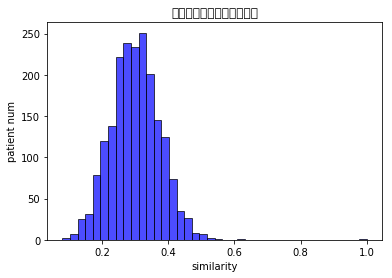

In [180]:
# 设置matplotlib正常显示中文和负号
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

plt.hist(matrix_patient_similarity[1010], bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("similarity")
# 显示纵轴标签
plt.ylabel("patient num")
# 显示图标题
plt.title("选定患者相似度分布直方图")
plt.show()

In [207]:
def getInfoOfChoosenItem(index_choosePatient=0,n_th_similar=0,n_th_nonsimilar=0):
    index_choosePatient = index_choosePatient
    n_th_similar = n_th_similar
    n_th_nonsimilar = n_th_nonsimilar
    hash_choose_patient = list_patientHash[index_choosePatient]
    hash_choose_patient_Nth_similar = list_patientHash[matrix_topN_similarIndex[index_choosePatient][n_th_similar]]
    hash_choose_patient_Nth_Nonsimilar = list_patientHash[matrix_topN_nonsimilarIndex[index_choosePatient][n_th_nonsimilar]]
    print(hash_choose_patient)
    print(hash_choose_patient_Nth_similar)
    print(hash_choose_patient_Nth_Nonsimilar)

    node_choose_patient = dict_hash_Node[hash_choose_patient]
    node_choose_patient_Nth_similar = dict_hash_Node[hash_choose_patient_Nth_similar]
    node_choose_patient_Nth_Nonsimilar = dict_hash_Node[hash_choose_patient_Nth_Nonsimilar]
    print(node_choose_patient)
    print(node_choose_patient_Nth_similar)
    print(node_choose_patient_Nth_Nonsimilar)
    
    value_choose_patient_Nth_similar = matrix_topN_similarValue[index_choosePatient][n_th_similar]
    value_choose_patient_Nth_Nonsimilar = matrix_topN_nonsimilarValue[index_choosePatient][n_th_nonsimilar]
    print(value_choose_patient_Nth_similar)
    print(value_choose_patient_Nth_Nonsimilar)

In [227]:
getInfoOfChoosenItem(index_choosePatient=19,n_th_similar=0,n_th_nonsimilar=0)

-6744873405680108371
-6744873405680114853
-6744873405680114805
(_3999:Patient {age: '75', patient_ID: 328623, sex: '\u7537'})
(_4201:Patient {age: '70', patient_ID: 369441, sex: '\u7537'})
(_4281:Patient {age: '95', patient_ID: 371070, sex: '\u7537'})
0.6788629554155953
0.03510833009050155
